### Análise e Pré-processamento do Ames Dataset

In [283]:
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 500)

In [284]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

c:\Users\giuli\OneDrive - Insper - Institudo de Ensino e Pesquisa\Documentos\insper\MachineLearning\data


In [285]:
processed_file_path = DATA_DIR / 'processed' / 'ames_with_correct_types.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)

##### *Análise das variáveis categóricas*

               count unique      top  freq
Misc.Feature     106      5     Shed    95
Alley            198      2     Grvl   120
Mas.Vnr.Type    1155      4  BrkFace   880
Garage.Type     2773      6   Attchd  1731
MS.SubClass     2930     16       20  1079
Central.Air     2930      2        Y  2734
Heating         2930      6     GasA  2885
Foundation      2930      6    PConc  1310
Exterior.2nd    2930     17  VinylSd  1015
Exterior.1st    2930     16  VinylSd  1026
Roof.Matl       2930      8  CompShg  2887
Roof.Style      2930      6    Gable  2321
House.Style     2930      8   1Story  1481
Bldg.Type       2930      5     1Fam  2425
Condition.2     2930      8     Norm  2900
Condition.1     2930      9     Norm  2522
Neighborhood    2930     28    NAmes   443
Lot.Config      2930      5   Inside  2140
Land.Contour    2930      4      Lvl  2633
Street          2930      2     Pave  2918
MS.Zoning       2930      7       RL  2273
Sale.Type       2930     10      WD   2536
Sale.Condit

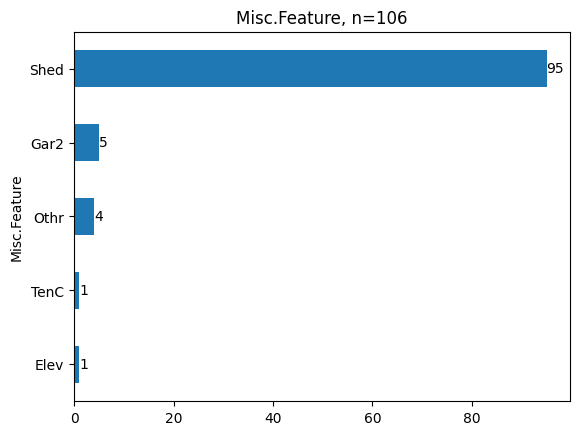

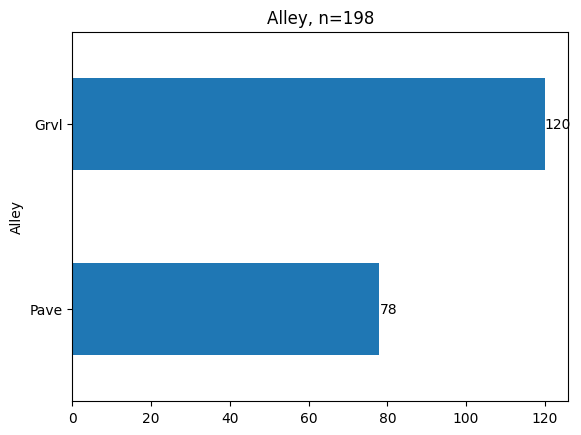

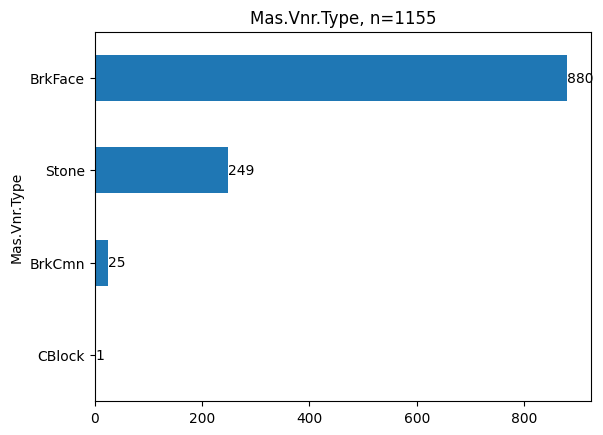

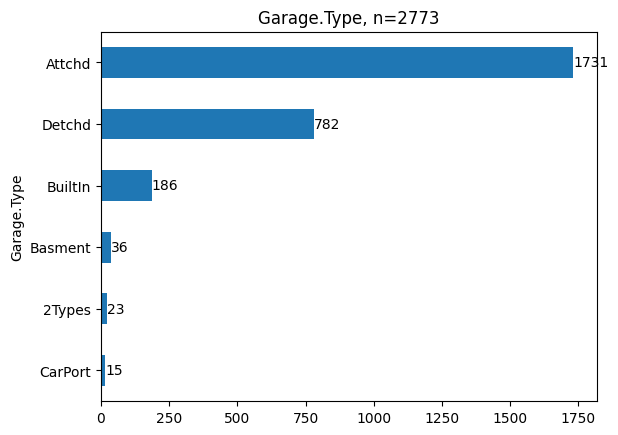

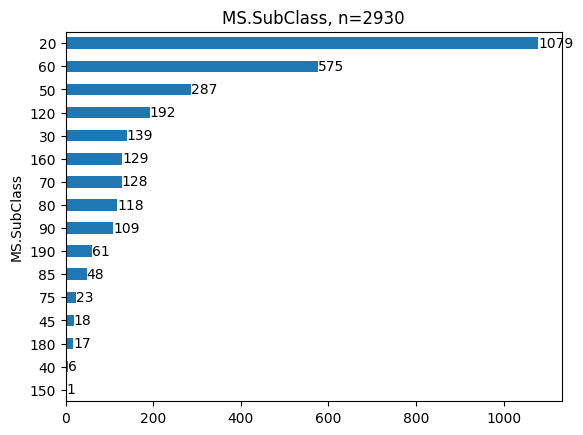

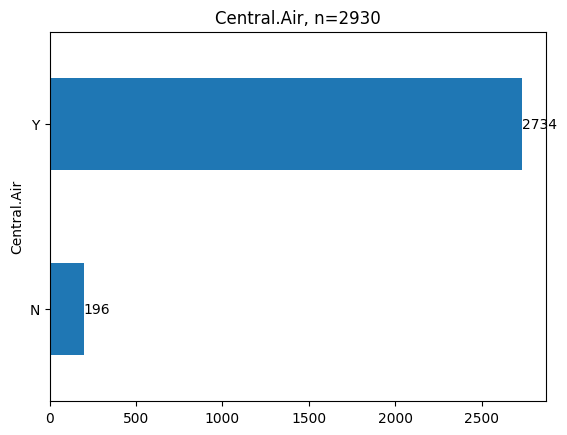

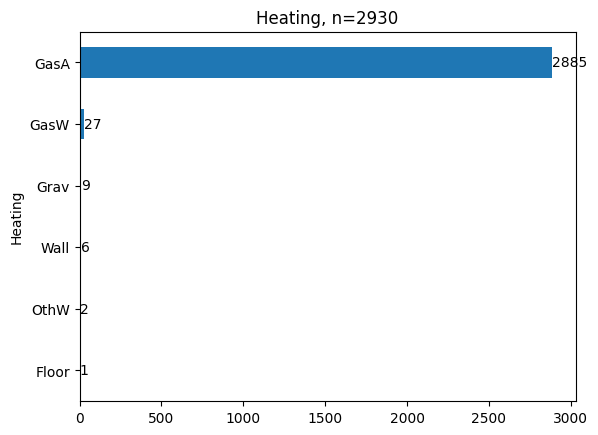

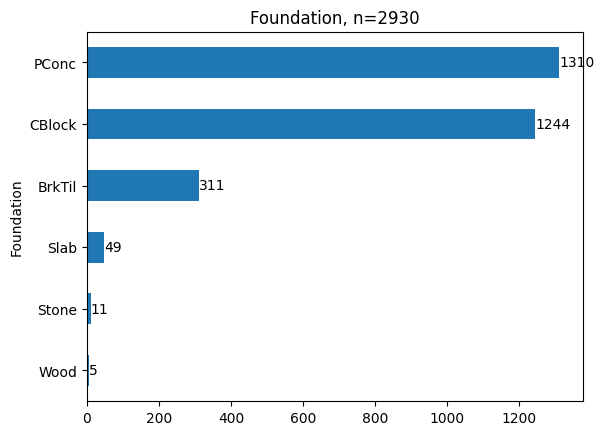

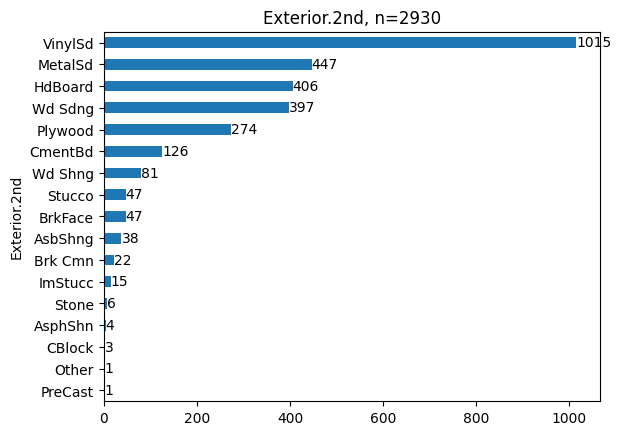

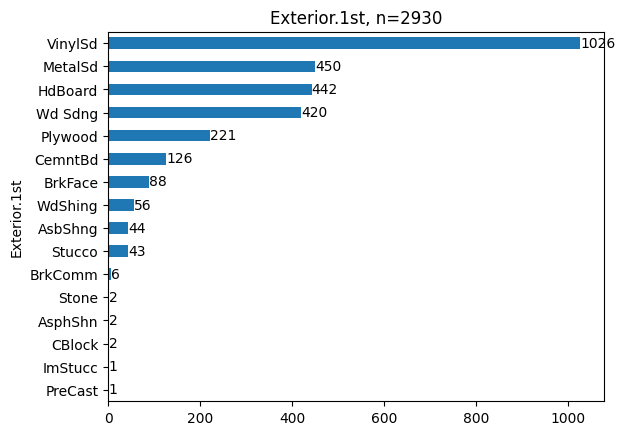

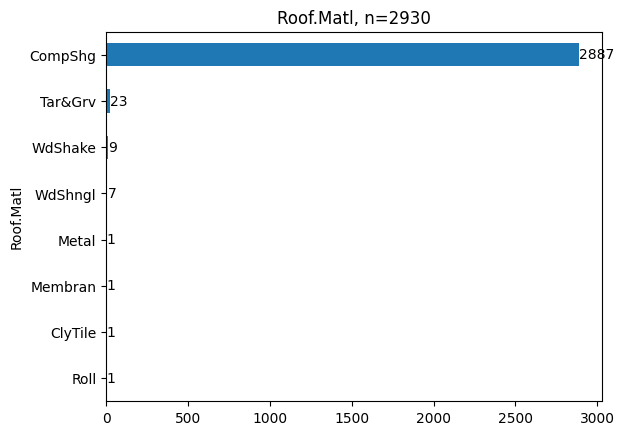

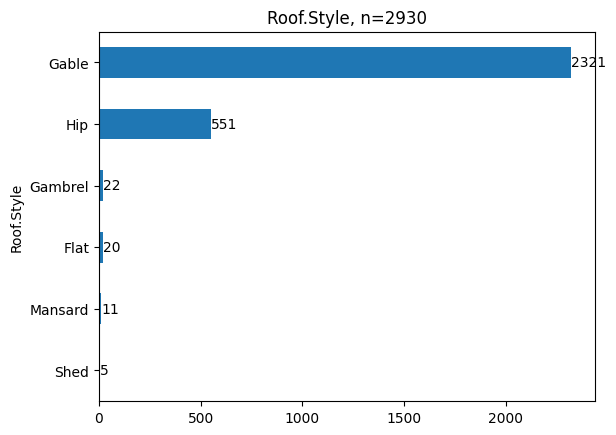

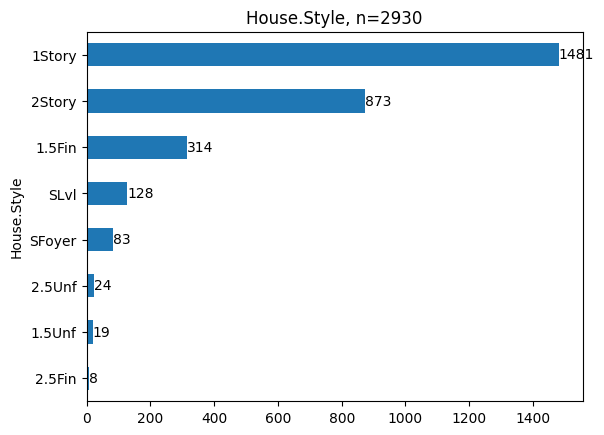

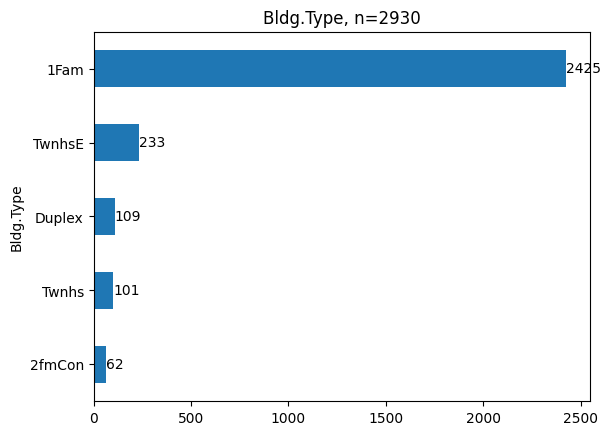

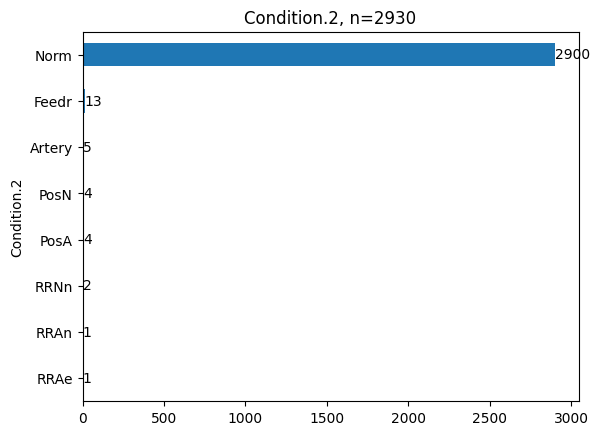

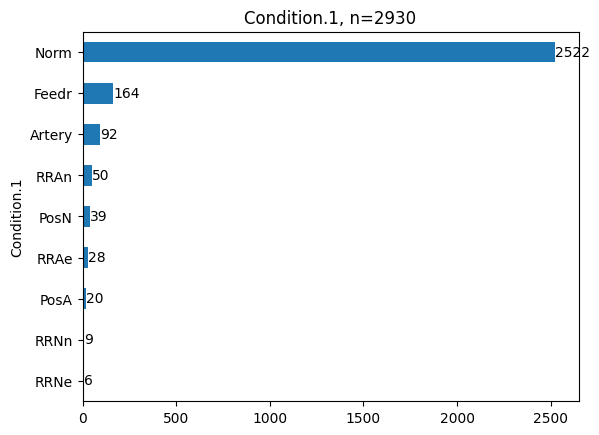

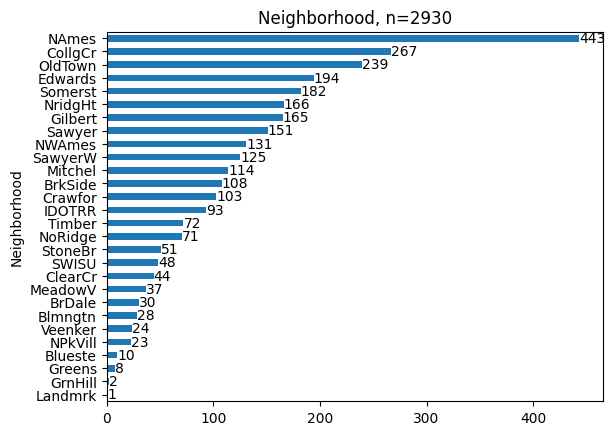

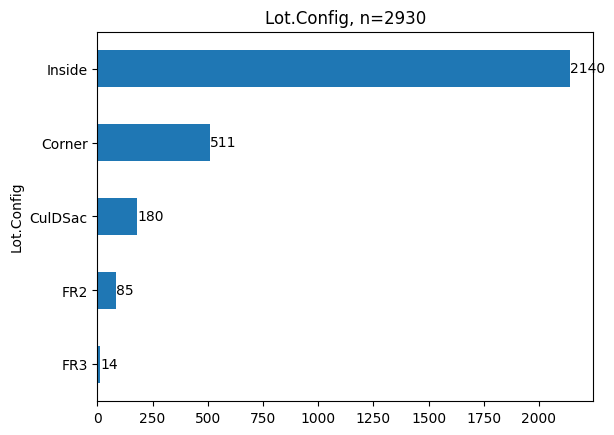

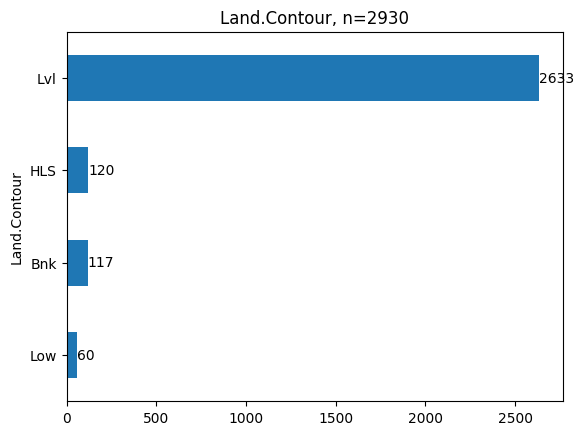

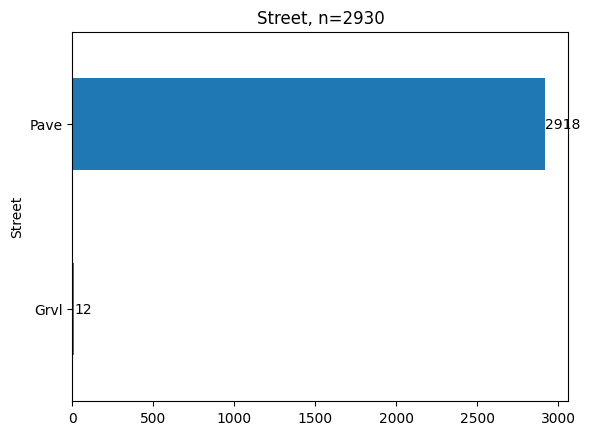

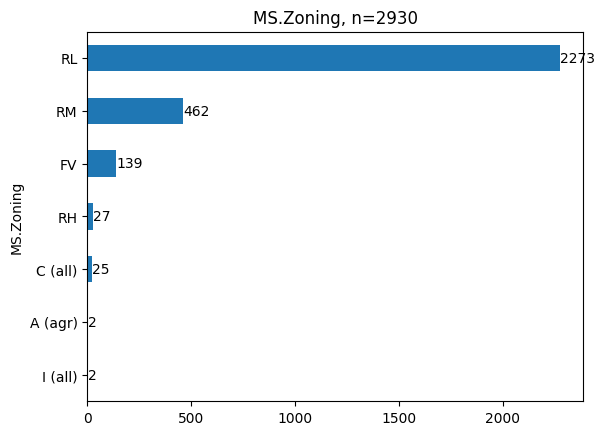

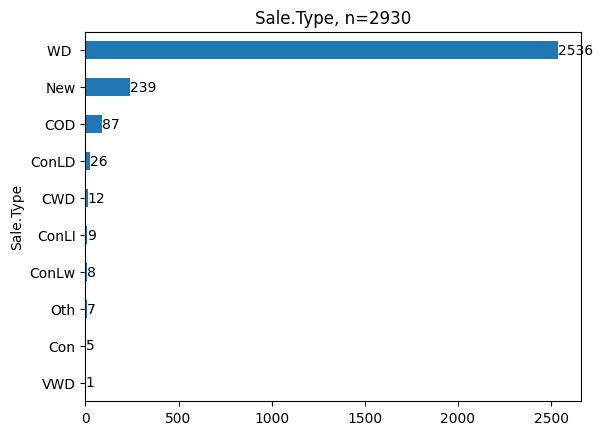

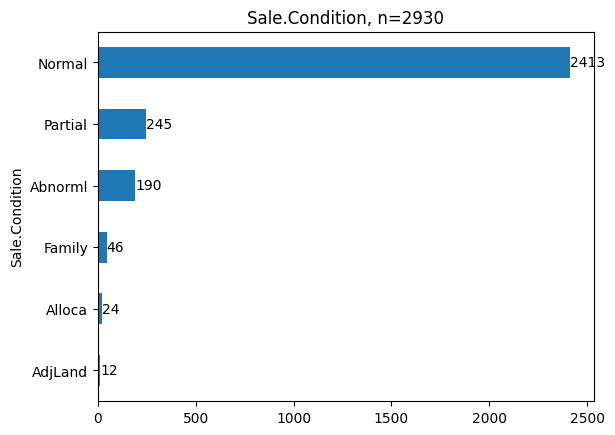

In [286]:
def plot_categoricals(data, cols, sorted=True):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        ser = data[col].value_counts()
        if sorted:
            ser = ser.sort_values()
        else:
            ser = ser.sort_index()
        ax = ser.plot.barh()
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

plot_categoricals(data, categorical_variables)

É importante observar:

- Há variáveis com muitas categorias que possuem pouca representação.
- Pode ser interessante remover as categorias minoritárias e registrar que o modelo que estamos desenvolvendo não é adequado para processar casas dessas categorias.
- Outra opção seria ignorar completamente as colunas desse tipo.
- Uma terceira alternativa é agrupar as categorias minoritárias em uma nova categoria chamada Outros, indicando que não estamos ignorando essas propriedades, mas que não há evidências suficientes para inferir o efeito das categorias minoritárias específicas sobre o preço de venda.

Algumas variáveis contêm um grande número de valores ausentes.
Pode ser melhor eliminar essas colunas ou atribuir todos os valores ausentes a uma categoria recém-criada chamada Desconhecido.

Para simplificar os dados, processaremos cada variável, removeremos outliers, etc.

Zoneamento Residencial, Tipos de Venda e Condições de Venda (MS.Zoning, Sale.Type, and Sale.Condition) vão ser analisadas primeiro, começando por Zoneamento Residencial.

In [287]:
data['MS.Zoning'].unique()

['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)']
Categories (7, object): ['A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM']

In [288]:
data['MS.Zoning'].value_counts()

MS.Zoning
RL         2273
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: count, dtype: int64

Observamos que um pequeno número de vendas é referente a propriedades não residenciais, especificamente as categorias C (all), A (agr) e I (all). Vamos removê-las.

In [289]:
selection = ~(data['MS.Zoning'].isin(['A (agr)', 'C (all)', 'I (all)']))
selection.value_counts()

MS.Zoning
True     2901
False      29
Name: count, dtype: int64

In [290]:
data = data[selection]

In [291]:
data['MS.Zoning'] = data['MS.Zoning'].cat.remove_unused_categories()
data['MS.Zoning'].value_counts()

MS.Zoning
RL    2273
RM     462
FV     139
RH      27
Name: count, dtype: int64

Agora vamos analisar os Tipos e Condições de Vendas.

In [292]:
data['Sale.Type'].value_counts()

Sale.Type
WD       2513
New       239
COD        85
ConLD      22
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64

In [293]:
data['Sale.Condition'].value_counts()

Sale.Condition
Normal     2397
Partial     245
Abnorml     179
Family       46
Alloca       22
AdjLand      12
Name: count, dtype: int64

Vamos realizar algumas reatribuições de categorias:

- Todos os tipos de escritura de garantia serão agrupados em uma categoria chamada GroupedWD.
- A categoria New permanecerá inalterada.
- Todas as categorias minoritárias restantes serão agrupadas em uma categoria chamada Other.

In [294]:
processed_data = data.copy()

In [295]:
def remap_categories(
    series: pd.Series,
    old_categories: tuple[str],
    new_category: str,
) -> pd.Series:
    # Add the new category to the list of valid categories.
    series = series.cat.add_categories(new_category)

    # Set all items of the old categories as the new category.
    remapped_items = series.isin(old_categories)
    series.loc[remapped_items] = new_category

    # Clean up the list of categories, the old categories no longer exist.
    series = series.cat.remove_unused_categories()

    return series

In [296]:
processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('WD ', 'CWD', 'VWD'),
    new_category='GroupedWD',
)

processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw'),
    new_category='Other',
)

In [297]:
processed_data['Sale.Type'].value_counts()

Sale.Type
GroupedWD    2526
New           239
Other         136
Name: count, dtype: int64

In [298]:
data = processed_data

Agora vamos analisar a coluna Rua (Street).

In [299]:
data['Street'].value_counts()

Street
Pave    2895
Grvl       6
Name: count, dtype: int64

In [300]:
data = data.drop(columns='Street')

Arredores da Residência (Condition.1 e Condition.2) vão ser analisadas agora.

In [301]:
data['Condition.1'].value_counts()

Condition.1
Norm      2500
Feedr      158
Artery      91
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: count, dtype: int64

In [302]:
data['Condition.2'].value_counts()

Condition.2
Norm      2872
Feedr       12
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: count, dtype: int64

In [303]:
pd.crosstab(data['Condition.1'], data['Condition.2'])

Condition.2,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn
Condition.1,,,,,,,,
Artery,2,0,88,1,0,0,0,0
Feedr,1,3,150,0,0,1,1,2
Norm,0,0,2500,0,0,0,0,0
PosA,0,0,17,3,0,0,0,0
PosN,0,0,35,0,4,0,0,0
RRAe,0,0,28,0,0,0,0,0
RRAn,1,8,41,0,0,0,0,0
RRNe,0,0,6,0,0,0,0,0
RRNn,1,1,7,0,0,0,0,0


Vamos reatribuir algumas categorias para agrupar características semelhantes:

- As categorias de proximidade à ferrovia (RRAn, RRAe, RRNn e RRNe) serão agrupadas em uma única categoria chamada Railroad.
- As categorias Feedr e Artery referem-se a ruas maiores que coletam o tráfego de ruas locais e conectam bairros (por exemplo, - grandes avenidas). Vamos agrupá-las em uma categoria chamada Roads.
- As categorias PosA e PosN referem-se a características positivas adjacentes ou próximas ao edifício. Vamos agrupá-las em uma categoria chamada Positive.

In [304]:
processed_data = data.copy()

In [305]:
for col in ('Condition.1', 'Condition.2'):
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('RRAn', 'RRAe', 'RRNn', 'RRNe'),
        new_category='Railroad',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('Feedr', 'Artery'),
        new_category='Roads',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('PosA', 'PosN'),
        new_category='Positive',
    )

In [306]:

processed_data['Condition.1'].value_counts()

Condition.1
Norm        2500
Roads        249
Railroad      93
Positive      59
Name: count, dtype: int64

In [307]:
processed_data['Condition.2'].value_counts()

Condition.2
Norm        2872
Roads         17
Positive       8
Railroad       4
Name: count, dtype: int64

In [308]:
pd.crosstab(processed_data['Condition.1'], processed_data['Condition.2'])

Condition.2,Norm,Railroad,Roads,Positive
Condition.1,,,,
Norm,2500,0,0,0
Railroad,82,0,11,0
Roads,238,4,6,1
Positive,52,0,0,7



Parece que podemos recombinar as colunas Condition.1 e Condition.2 em uma única coluna categórica com as seguintes categorias:

- Norm: Quando Condition.1 é Norm.
- Railroad: Quando Condition.1 é Railroad e Condition.2 é Norm.
- Roads: Quando Condition.1 é Roads e Condition.2 não é Railroad.
- Positive: Quando Condition.1 é Positive.
- RoadsAndRailroad: Quando (Condition.1 é Railroad e Condition.2 é Roads) ou (Condition.1 é Roads e Condition.2 é Railroad).

In [309]:
processed_data['Condition'] = pd.Series(
    index=processed_data.index,
    dtype=pd.CategoricalDtype(categories=(
        'Norm',
        'Railroad',
        'Roads',
        'Positive',
        'RoadsAndRailroad',
    )),
)

In [310]:
norm_items = processed_data['Condition.1'] == 'Norm'
processed_data['Condition'][norm_items] = 'Norm'

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\3094731605.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  processed_data['Condition'][norm_items] = 'Norm'


In [311]:
railroad_items = \
    (processed_data['Condition.1'] == 'Railroad') \
    & (processed_data['Condition.2'] == 'Norm')
processed_data['Condition'][railroad_items] = 'Railroad'

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\1159928309.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  processed_data['Condition'][railroad_items] = 'Railroad'


In [312]:
roads_items = \
    (processed_data['Condition.1'] == 'Roads') \
    & (processed_data['Condition.2'] != 'Railroad')
processed_data['Condition'][roads_items] = 'Roads'

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\4278367953.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  processed_data['Condition'][roads_items] = 'Roads'


In [313]:
positive_items = processed_data['Condition.1'] == 'Positive'
processed_data['Condition'][positive_items] = 'Positive'

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\3872231646.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  processed_data['Condition'][positive_items] = 'Positive'


In [314]:
roads_and_railroad_items = \
    ( \
        (processed_data['Condition.1'] == 'Railroad') \
        & (processed_data['Condition.2'] == 'Roads')
    ) \
    | ( \
        (processed_data['Condition.1'] == 'Roads') \
        & (processed_data['Condition.2'] == 'Railroad') \
    )
processed_data['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\576926537.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  processed_data['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'


In [315]:
processed_data['Condition'].value_counts()

Condition
Norm                2500
Roads                245
Railroad              82
Positive              59
RoadsAndRailroad      15
Name: count, dtype: int64

In [316]:
processed_data = processed_data.drop(columns=['Condition.1', 'Condition.2'])
data = processed_data

Vamos analisar as colunas Recursos Diversos (Misc.Feature) e Beco (Alley).

As colunas Misc.Feature e Alley são, em sua maioria, compostas por valores ausentes!

             count unique   top freq
Misc.Feature   104      5  Shed   93
Alley          195      2  Grvl  119


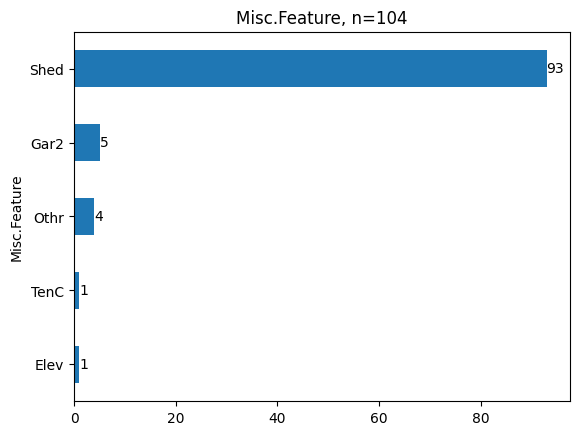

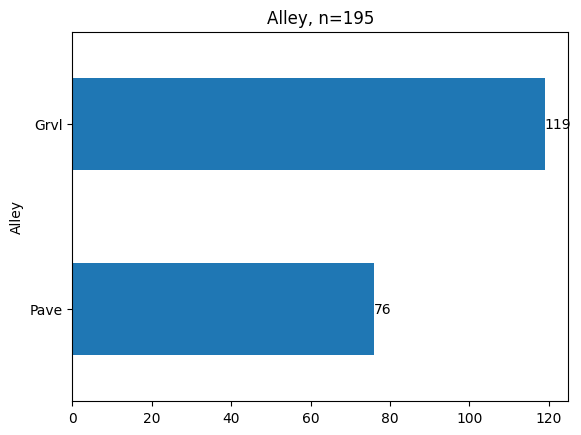

In [317]:
plot_categoricals(data, ['Misc.Feature', 'Alley'])

Mas parece que ainda podemos reutilizar essas informações. Podemos transformar a variável Misc.Feature em uma variável HasShed, que indica se a casa possui um galpão:

In [318]:
data['HasShed'] = data['Misc.Feature'] == 'Shed'
data = data.drop(columns='Misc.Feature')
data['HasShed'].value_counts()

HasShed
False    2808
True       93
Name: count, dtype: int64


Da mesma forma, podemos transformar a variável Alley em uma variável HasAlley, que indica se a casa possui um beco:

In [319]:
data['HasAlley'] = ~data['Alley'].isna()
data = data.drop(columns='Alley')
data['HasAlley'].value_counts()

HasAlley
False    2706
True      195
Name: count, dtype: int64

As coberturas externas (Exterior.1st e Exterior.2nd) possuem muitas categorias, algumas com baixa representatividade:

             count unique      top  freq
Exterior.1st  2901     16  VinylSd  1025
Exterior.2nd  2901     17  VinylSd  1012


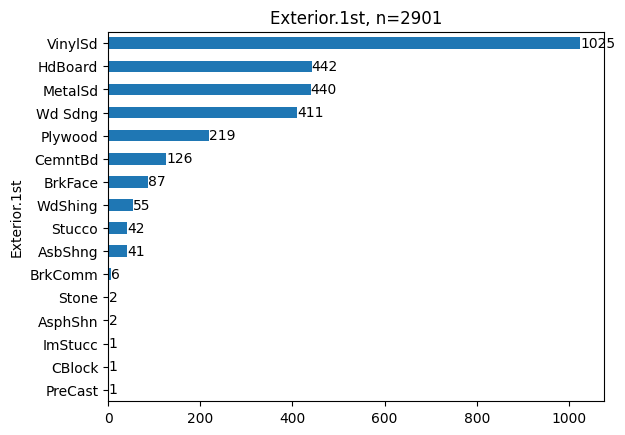

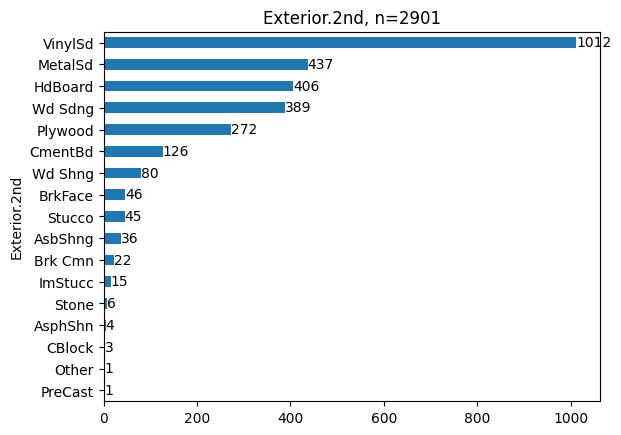

In [320]:

plot_categoricals(data, ['Exterior.1st', 'Exterior.2nd'])

In [321]:
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Brk Cmn', ),
    new_category='BrkComm',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('CmentBd', ),
    new_category='CemntBd',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Wd Shng', ),
    new_category='WdShing',
)
for col in ('Exterior.1st', 'Exterior.2nd'):
    categories = data[col].cat.categories
    data[col] = data[col].cat.reorder_categories(sorted(categories))
pd.crosstab(data['Exterior.1st'], data['Exterior.2nd'])

Exterior.2nd,AsbShng,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,Wd Sdng,WdShing
Exterior.1st,,,,,,,,,,,,,,,,,
AsbShng,33,0,0,0,0,1,0,0,0,0,5,0,0,1,0,1,0
AsphShn,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BrkComm,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,1,0
BrkFace,1,0,0,43,0,0,3,0,3,0,8,0,3,3,1,21,1
CBlock,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
CemntBd,0,0,0,0,0,124,0,0,0,0,0,0,0,0,0,1,1
HdBoard,0,1,0,1,0,0,383,6,1,0,41,0,0,1,0,3,5
ImStucc,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
MetalSd,0,1,0,0,1,0,3,0,427,0,0,0,0,3,2,2,1



Parece que existem algumas opções populares e muitos materiais com baixa representatividade além das opções populares. Devido à falta de representatividade, vamos manter apenas as categorias populares como estão e agrupar o restante em uma categoria chamada Other.

Além disso, parece ser comum que o primeiro material seja o mesmo que o segundo, provavelmente para indicar que o exterior da casa contém apenas um material. Portanto, vamos manter apenas a variável Exterior.1st.

In [322]:
processed_data = data.copy()
mat_count = processed_data['Exterior.1st'].value_counts()
mat_count

Exterior.1st
VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
BrkComm       6
AsphShn       2
Stone         2
CBlock        1
ImStucc       1
PreCast       1
Name: count, dtype: int64

In [323]:
rare_materials = list(mat_count[mat_count < 40].index)
rare_materials

['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'PreCast']

In [324]:
processed_data['Exterior'] = remap_categories(
    series=processed_data['Exterior.1st'],
    old_categories=rare_materials,
    new_category='Other',
)
processed_data = processed_data.drop(columns=['Exterior.1st', 'Exterior.2nd'])
processed_data['Exterior'].value_counts()

Exterior
VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
Other        13
Name: count, dtype: int64

In [325]:
data = processed_data

Agora vamos analisar a coluna Aquecimento (Heating).

        count unique   top  freq
Heating  2901      6  GasA  2859


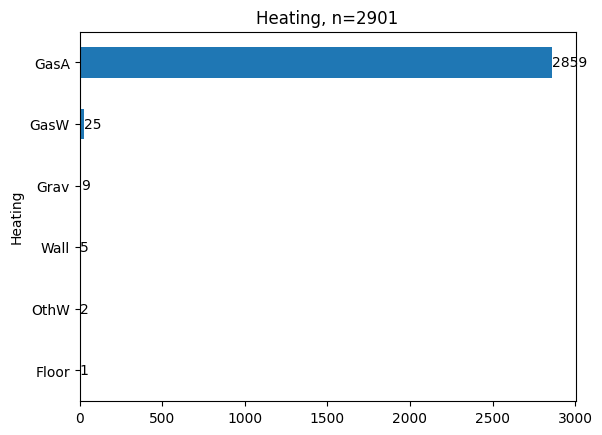

In [326]:
plot_categoricals(data, ['Heating',])


Essa coluna não possui valores ausentes, e a grande maioria dos itens pertence à mesma categoria. Sendo assim, não há muita informação relevante aqui, vamos descartar a coluna.

In [327]:

data = data.drop(columns='Heating')

Vamos analisar agora as colunas de Material do Telhado (Roof.Matl) e do Estilo do Telhado (Roof.Style).

           count unique      top  freq
Roof.Matl   2901      8  CompShg  2858
Roof.Style  2901      6    Gable  2301


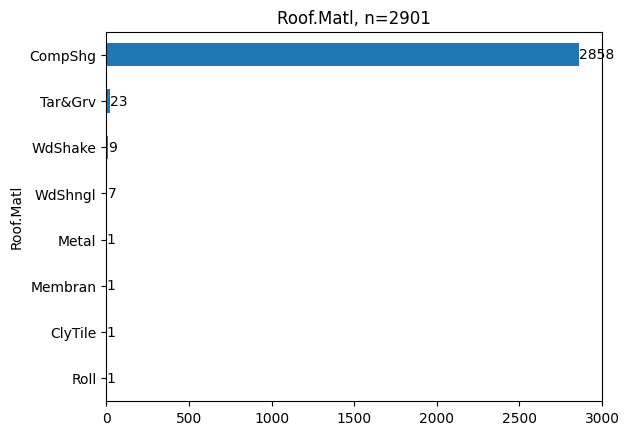

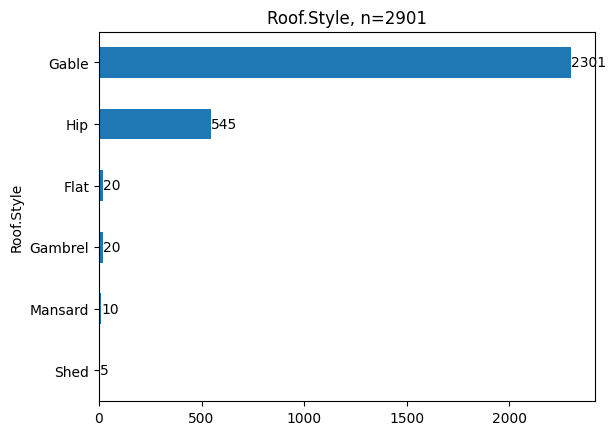

In [328]:
plot_categoricals(data, ['Roof.Matl', 'Roof.Style'])


Devido à baixa representatividade das categorias minoritárias na variável Roof.Matl, vamos descartá-la.

In [329]:
data = data.drop(columns='Roof.Matl')

Na variável Roof.Style, temos duas categorias substanciais e algumas muito minoritárias. Vamos agrupar as categorias minoritárias em uma categoria chamada Other.

In [330]:
data['Roof.Style'] = remap_categories(
    series=data['Roof.Style'],
    old_categories=[
        'Flat',
        'Gambrel',
        'Mansard',
        'Shed',
    ],
    new_category='Other',
)
data['Roof.Style'].value_counts()

Roof.Style
Gable    2301
Hip       545
Other      55
Name: count, dtype: int64

A variável Mas.Vnr.Type se refere ao tipo de revestimento externo da casa (como pedras ou tijolos), utilizado para o acabamento da fachada. Vamos analisá-la agora.

In [331]:
data['Mas.Vnr.Type'].value_counts()

Mas.Vnr.Type
BrkFace    880
Stone      249
BrkCmn      25
CBlock       1
Name: count, dtype: int64


Vamos agrupar as duas classes minoritárias da variável Mas.Vnr.Type em uma categoria chamada Other. Além disso, vamos adicionar as entradas ausentes à categoria None, já que não temos evidências do tipo de revestimento (veneer) nesses casos.

In [332]:
data['Mas.Vnr.Type'] = remap_categories(
    series=data['Mas.Vnr.Type'],
    old_categories=[
        'BrkCmn',
        'CBlock',
    ],
    new_category='Other',
)

In [333]:
data['Mas.Vnr.Type'] = data['Mas.Vnr.Type'].cat.add_categories('None')
data['Mas.Vnr.Type'][data['Mas.Vnr.Type'].isna()] = 'None'
data['Mas.Vnr.Type'].value_counts()

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\2348042553.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Mas.Vnr.Type'][data['Mas.Vnr.Type'].isna()] = 'None'


Mas.Vnr.Type
None       1746
BrkFace     880
Stone       249
Other        26
Name: count, dtype: int64

A variável MS.SubClass se refere à classificação do tipo de imóvel, geralmente categorizando as casas com base em suas características ou no tipo de construção.

             count  unique  top  freq
MS.SubClass   2901      16   20  1074


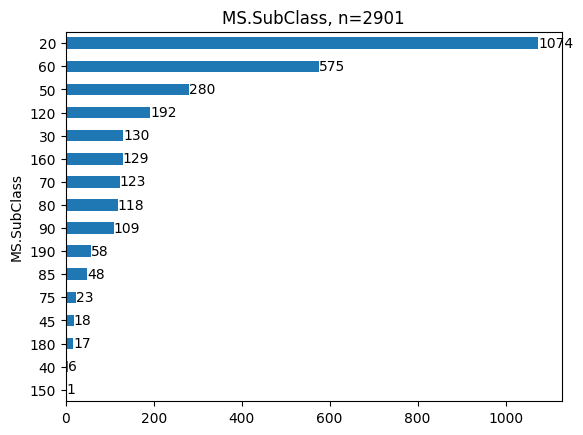

In [334]:
plot_categoricals(data, ['MS.SubClass'])

Vamos reatribuir as categorias minoritárias da variável MS.SubClass para uma categoria chamada Other.

In [335]:
data['MS.SubClass'] = remap_categories(
    series=data['MS.SubClass'],
    old_categories=[75, 45, 180, 40, 150],
    new_category='Other',
)
data['MS.SubClass'].value_counts()

MS.SubClass
20       1074
60        575
50        280
120       192
30        130
160       129
70        123
80        118
90        109
Other      65
190        58
85         48
Name: count, dtype: int64

Agora vamos analisar a coluna Fundação (Foundation).

           count unique    top  freq
Foundation  2901      6  PConc  1308


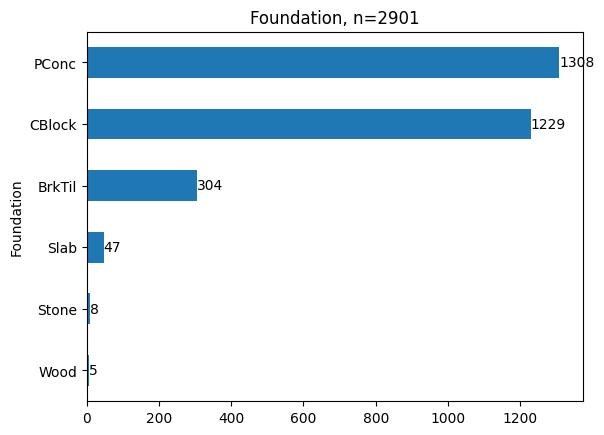

In [336]:
plot_categoricals(data, ['Foundation'])

In [337]:
data['Foundation'] = remap_categories(
    series=data['Foundation'],
    old_categories=['Slab', 'Stone', 'Wood'],
    new_category='Other',
)

Vamos analisar a coluna Vizinhança (Neighborhood).

In [338]:
data['Neighborhood'].value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    237
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    113
BrkSide    108
Crawfor    103
Timber      72
NoRidge     71
IDOTRR      68
StoneBr     51
SWISU       47
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: count, dtype: int64


Vamos descartar as linhas correspondentes às categorias minoritárias e fazer uma anotação de que este modelo não é adequado para esses bairros.

In [339]:
selection = ~data['Neighborhood'].isin([
    'Blueste',
    'Greens',
    'GrnHill',
    'Landmrk',
])
data = data[selection]
data['Neighborhood'] = data['Neighborhood'].cat.remove_unused_categories()
data['Neighborhood'].value_counts()

Neighborhood
NAmes      443
CollgCr    267
OldTown    237
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    113
BrkSide    108
Crawfor    103
Timber      72
NoRidge     71
IDOTRR      68
StoneBr     51
SWISU       47
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Name: count, dtype: int64

Seguimos analisando as colunas, vamos agora para a coluna Garagem (Garage.Type).

In [340]:
data['Garage.Type'].value_counts()

Garage.Type
Attchd     1714
Detchd      761
BuiltIn     186
Basment      35
2Types       23
CarPort      14
Name: count, dtype: int64

Parece que há algumas residências que não possuem garagem. Vamos criar uma categoria chamada NoGarage para essas casas.

In [341]:
data['Garage.Type'] = data['Garage.Type'].cat.add_categories(['NoGarage'])
data['Garage.Type'][data['Garage.Type'].isna()] = 'NoGarage'
data['Garage.Type'].value_counts()

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\3613131441.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Garage.Type'][data['Garage.Type'].isna()] = 'NoGarage'


Garage.Type
Attchd      1714
Detchd       761
BuiltIn      186
NoGarage     147
Basment       35
2Types        23
CarPort       14
Name: count, dtype: int64

Após todo esse processamento, o conjunto de variáveis categóricas foi alterado. Vamos criar uma nova lista com as variáveis categóricas atualizadas:

               count unique        top  freq
MS.SubClass     2880     12         20  1074
MS.Zoning       2880      4         RL  2265
Land.Contour    2880      4        Lvl  2594
Lot.Config      2880      5     Inside  2103
Neighborhood    2880     24      NAmes   443
Bldg.Type       2880      5       1Fam  2399
House.Style     2880      8     1Story  1454
Roof.Style      2880      3      Gable  2280
Mas.Vnr.Type    2880      4       None  1726
Foundation      2880      4      PConc  1306
Central.Air     2880      2          Y  2702
Garage.Type     2880      7     Attchd  1714
Sale.Type       2880      3  GroupedWD  2506
Sale.Condition  2880      6     Normal  2376
Condition       2880      5       Norm  2479
Exterior        2880     11    VinylSd  1024


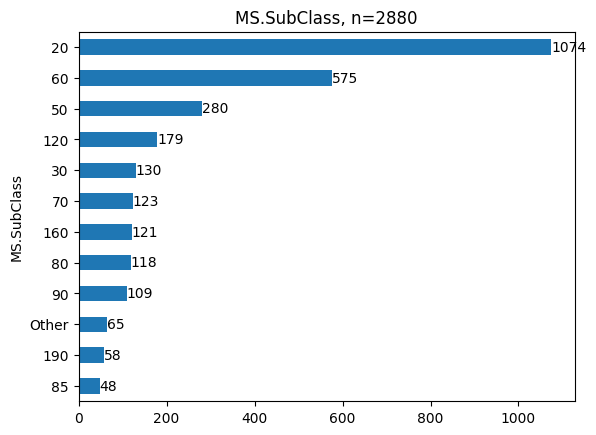

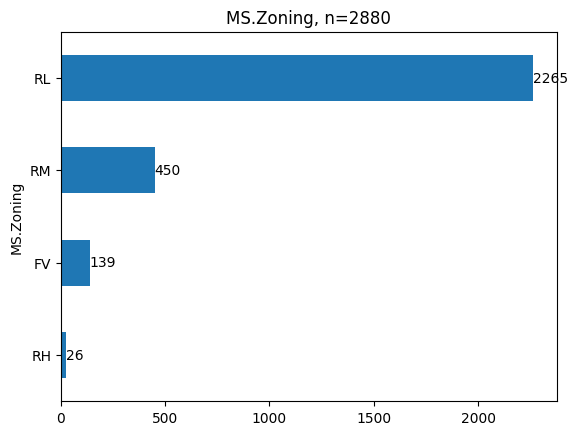

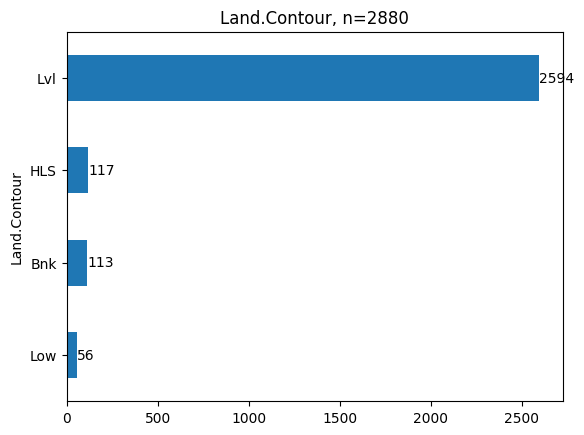

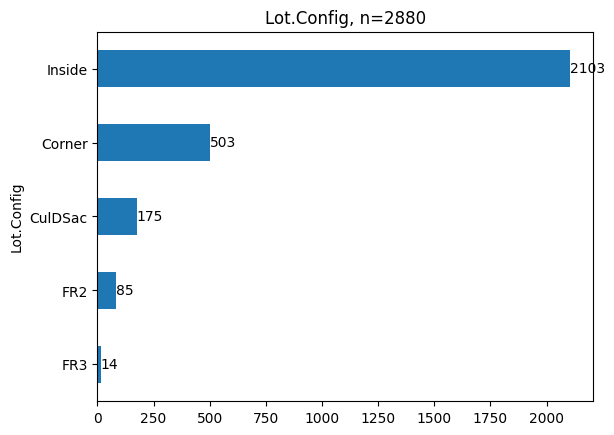

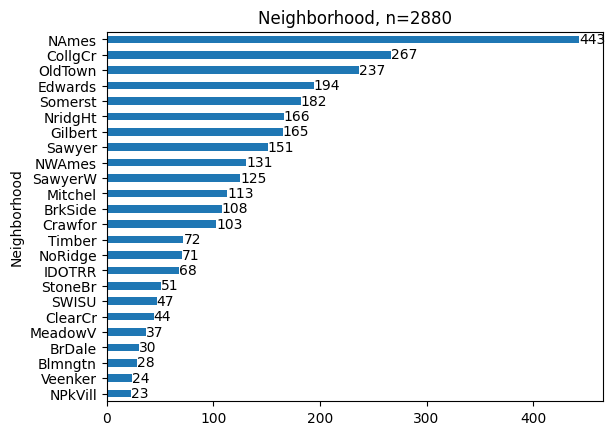

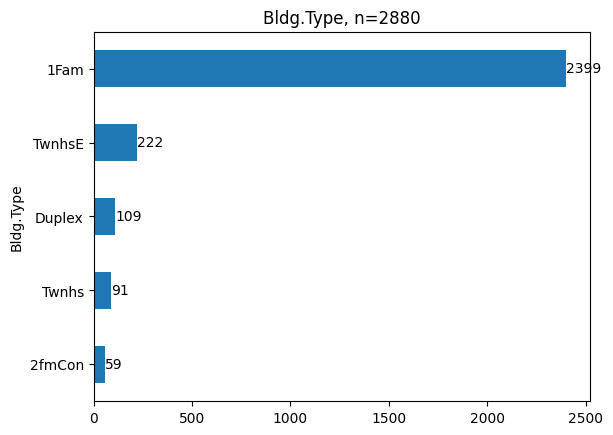

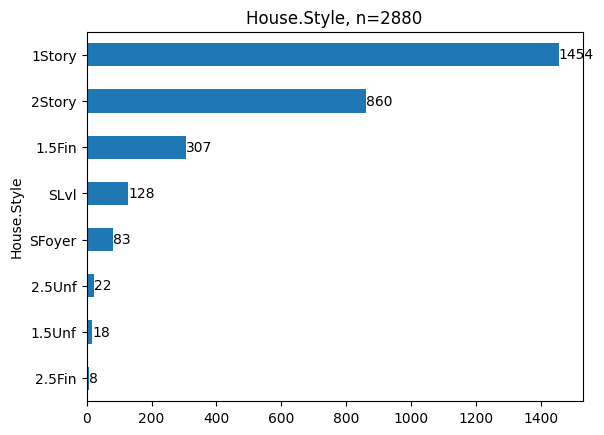

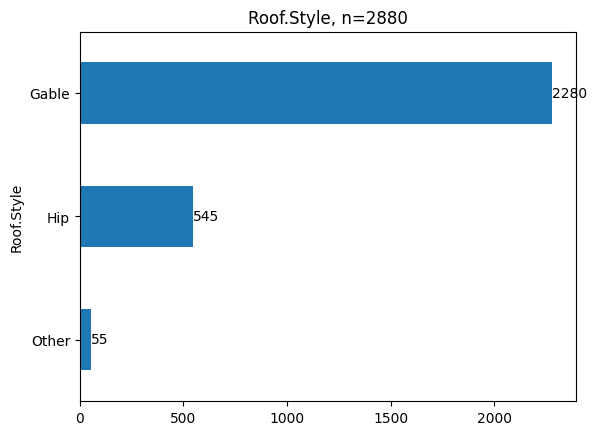

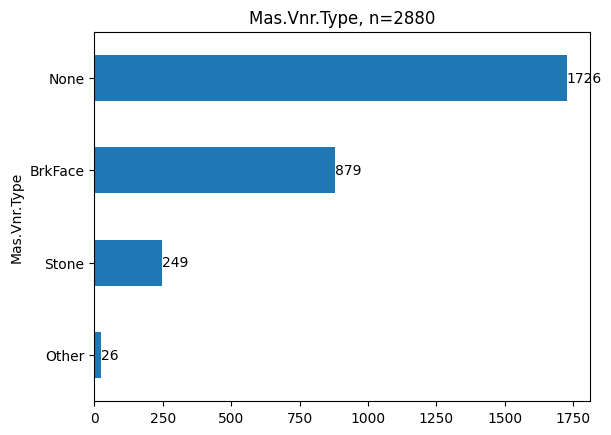

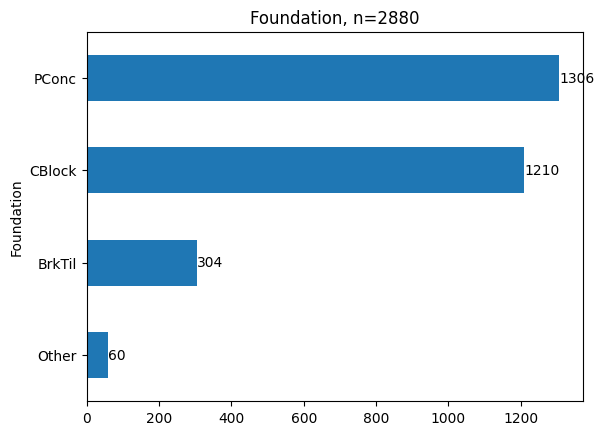

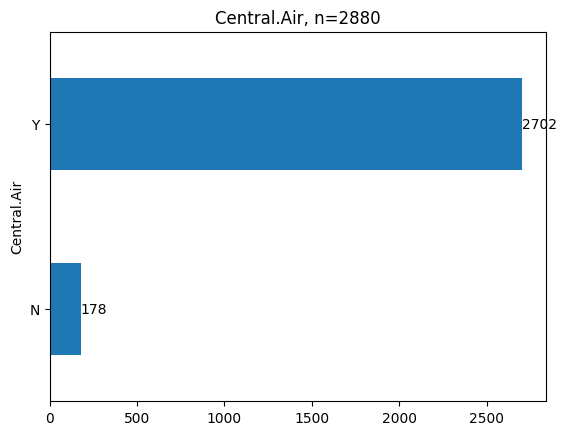

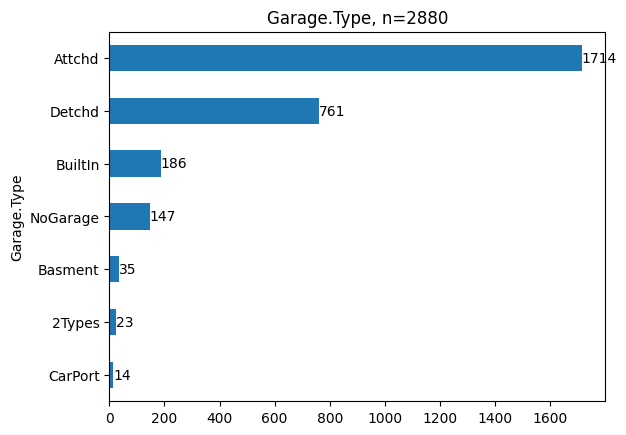

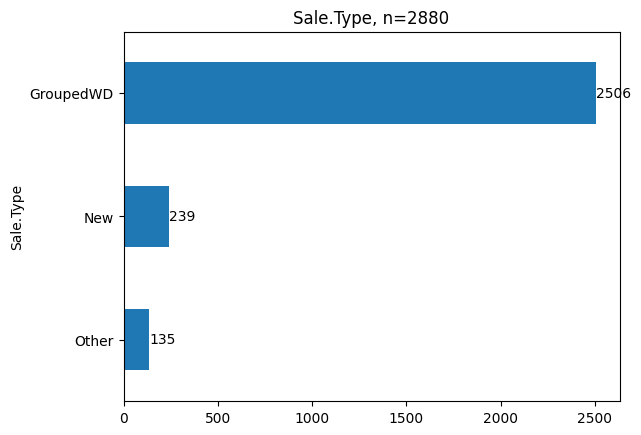

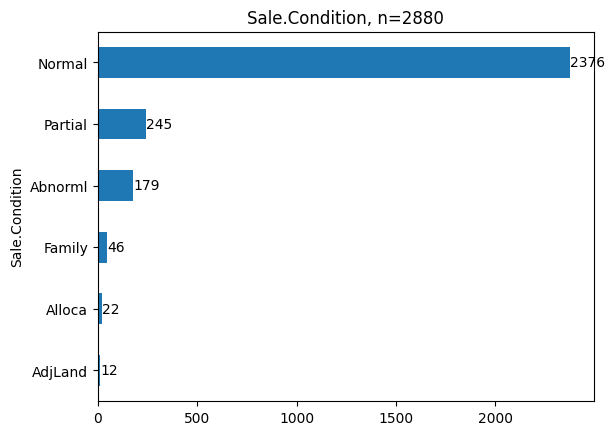

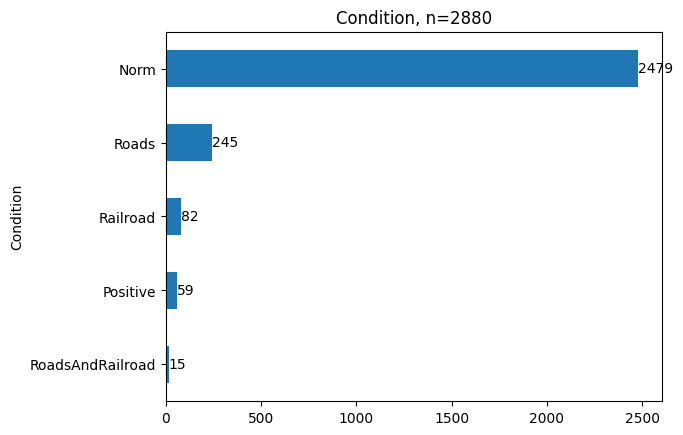

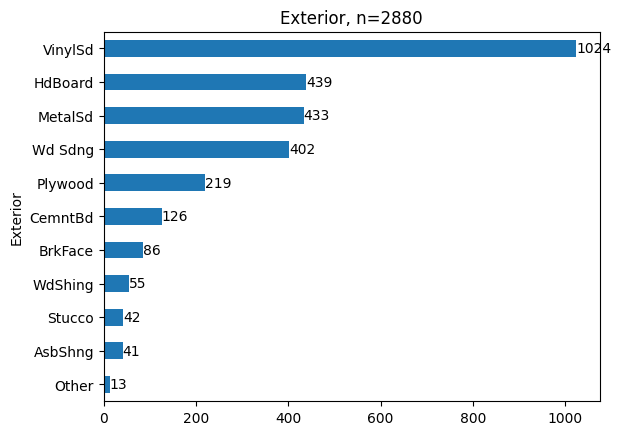

In [342]:
all_categorical = data.select_dtypes('category').columns

new_categorical_variables = [ \
    col for col in all_categorical \
    if not col in ordinal_variables \
]
plot_categoricals(data, new_categorical_variables)

##### *Análise das variáveis ordinais*

               count unique     top  freq
Pool.QC           13      4      Ex     4
Fence            561      4   MnPrv   325
Fireplace.Qu    1488      5      Gd   742
Garage.Cond     2731      5      TA  2631
Garage.Qual     2731      5      TA  2580
Garage.Finish   2731      3     Unf  1210
Bsmt.Exposure   2802      4      No  1879
BsmtFin.Type.2  2804      6     Unf  2459
Bsmt.Cond       2805      5      TA  2577
BsmtFin.Type.1  2805      6     GLQ   843
Bsmt.Qual       2805      4      TA  1262
Electrical      2879      5   SBrkr  2643
Exter.Cond      2880      5      TA  2513
Exter.Qual      2880      4      TA  1770
Heating.QC      2880      5      Ex  1487
Kitchen.Qual    2880      5      TA  1462
Functional      2880      8     Typ  2685
Overall.Cond    2880      9       5  1638
Overall.Qual    2880     10       5   820
Land.Slope      2880      3     Gtl  2746
Utilities       2880      3  AllPub  2878
Paved.Drive     2880      3       Y  2623
Lot.Shape       2880      4     Re

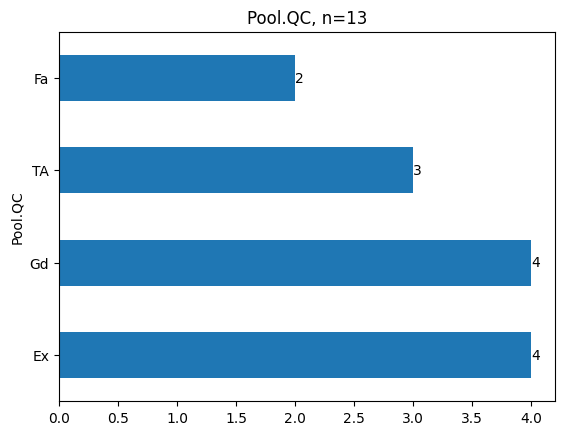

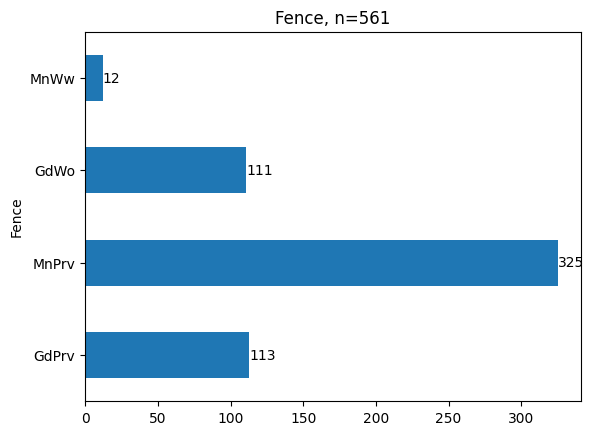

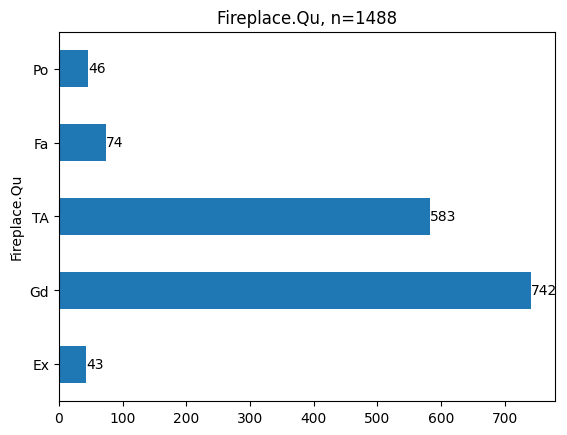

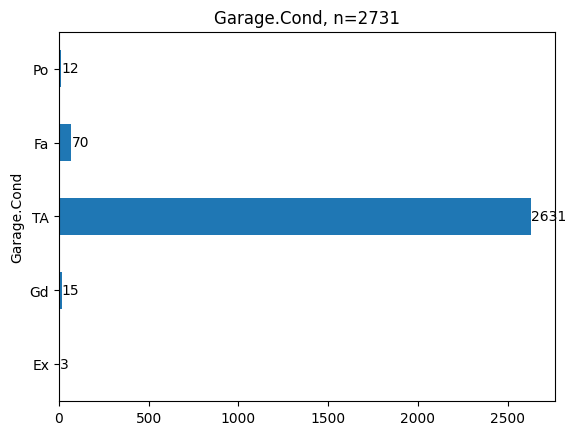

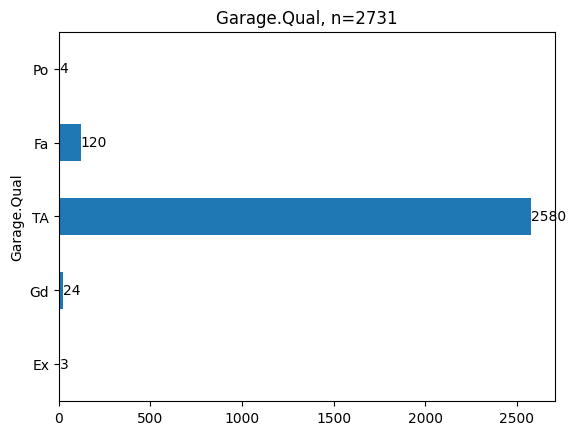

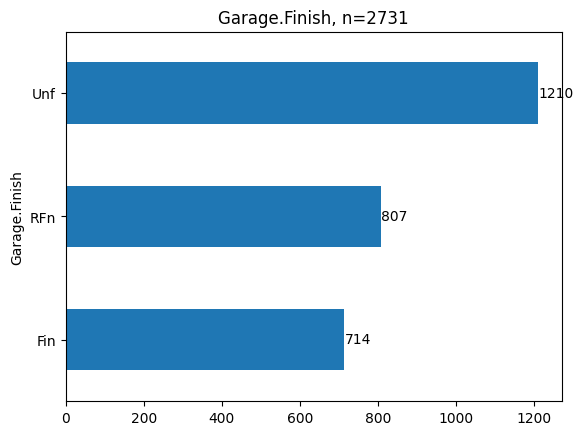

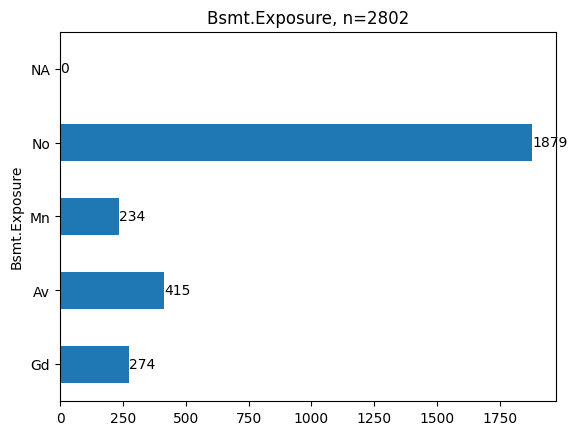

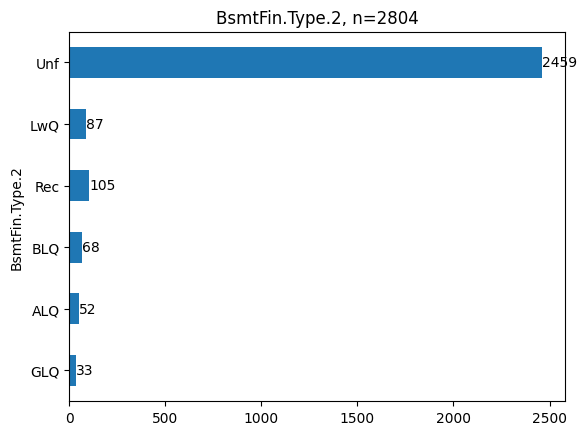

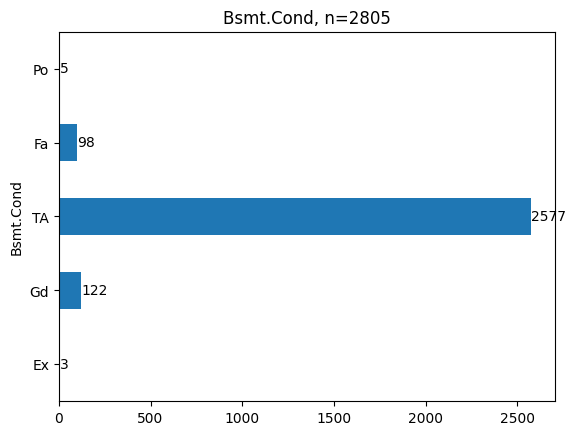

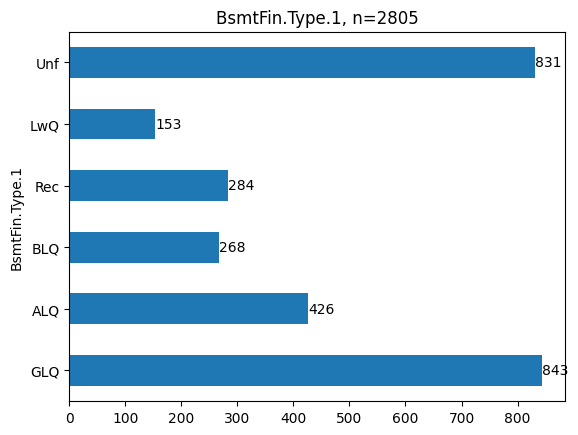

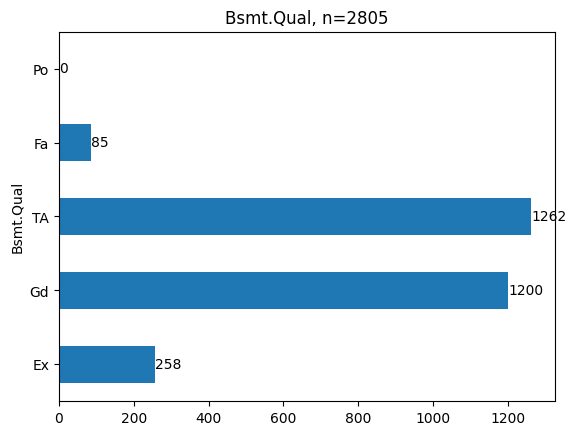

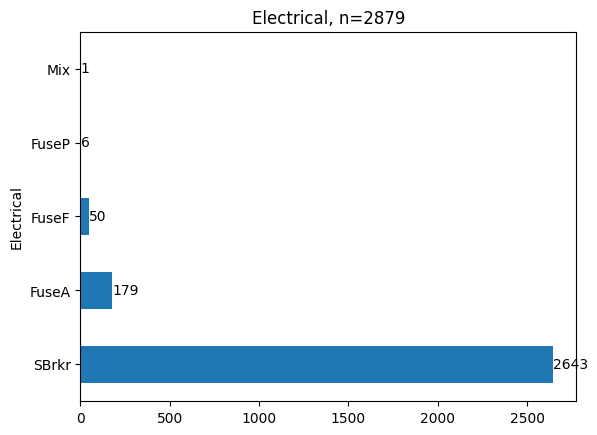

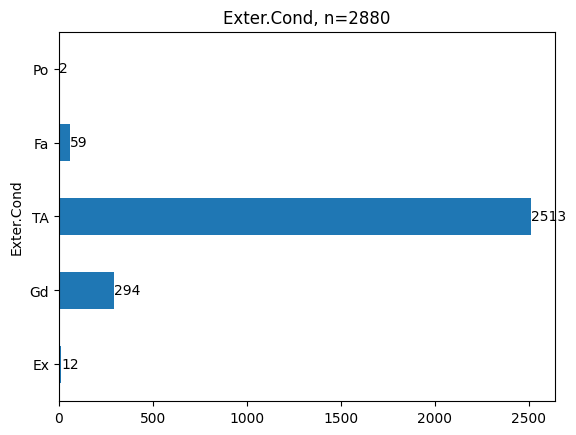

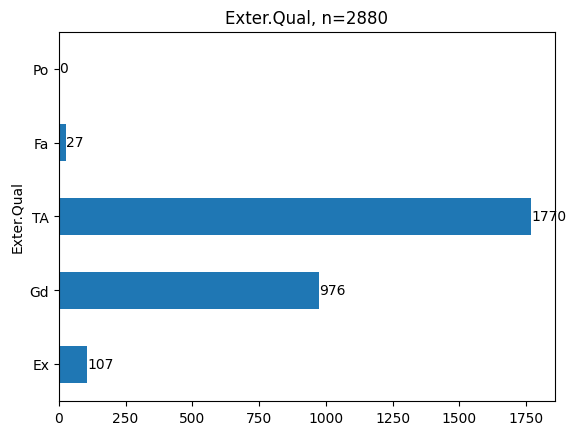

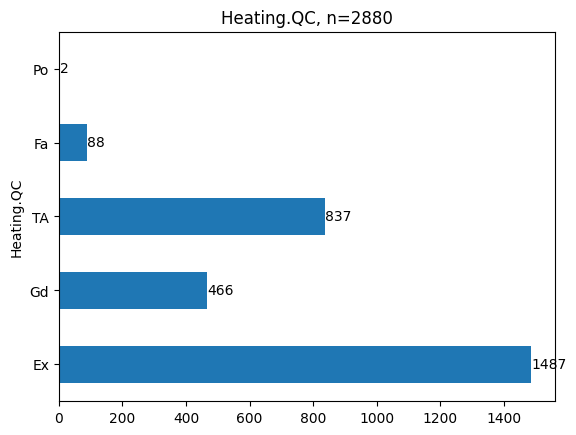

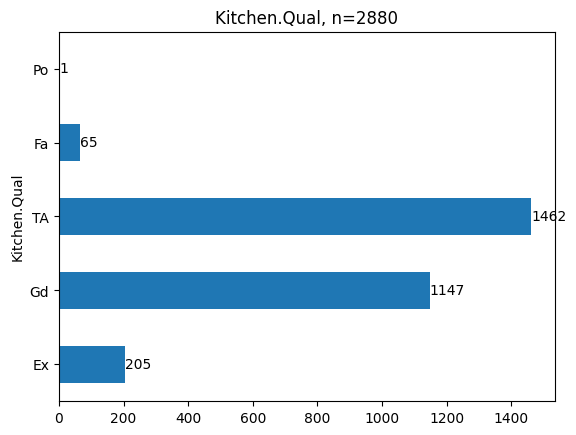

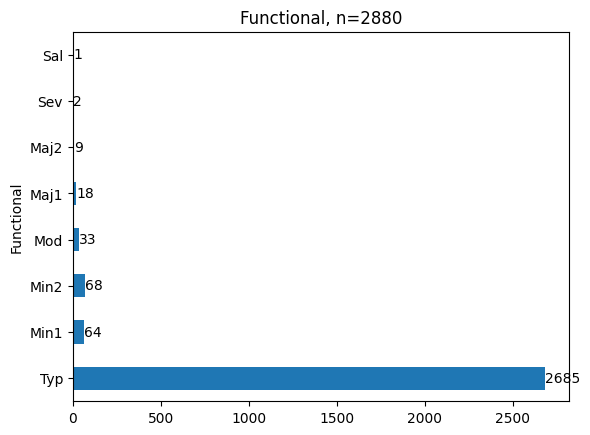

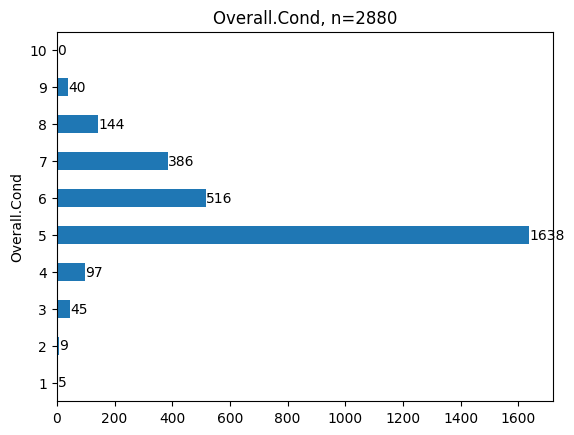

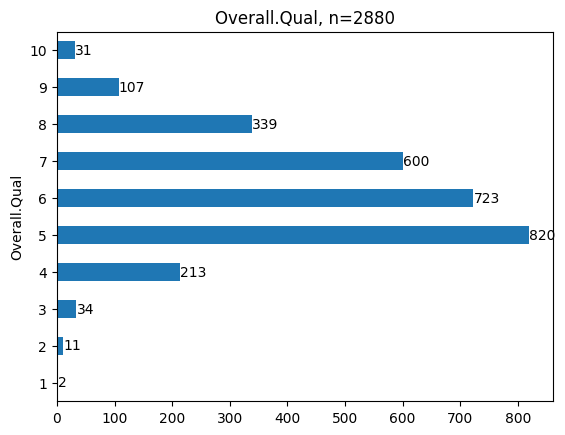

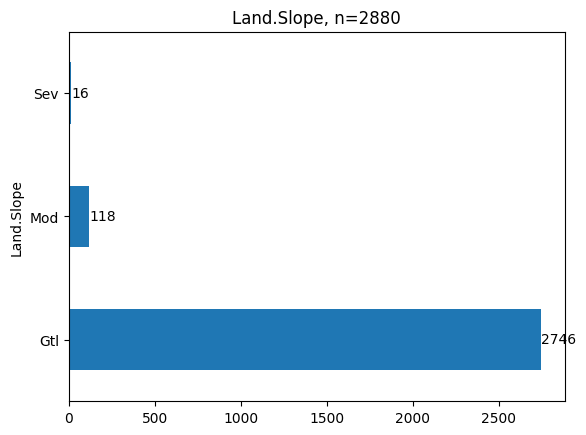

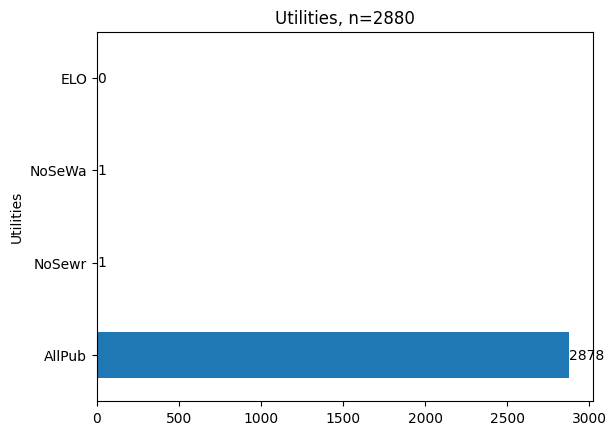

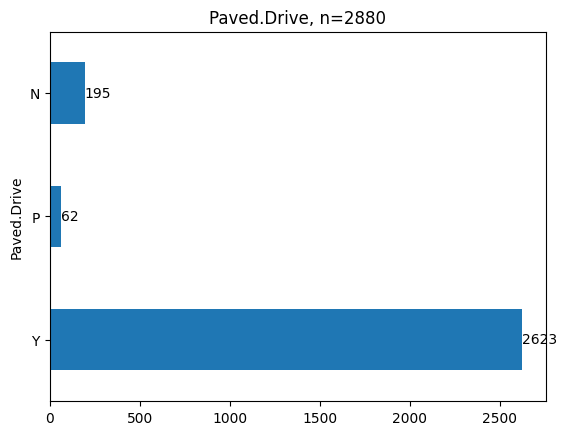

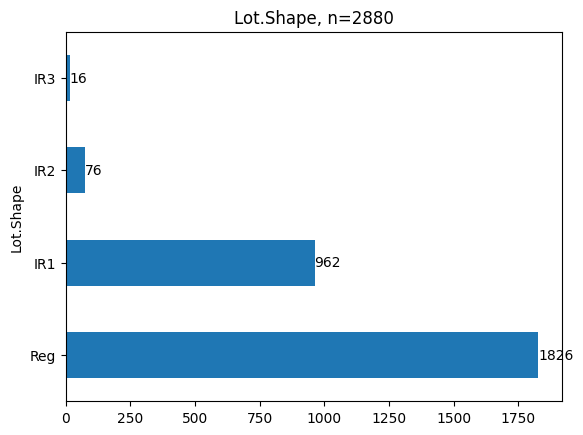

In [343]:
plot_categoricals(data, ordinal_variables, sorted=False)

Os problemas que restam a serem abordados são:

- Casos extremos de baixa representatividade
- Grande quantidade de valores ausentes

Vamos começar pela categoria Utilidades (Utilities).

In [344]:
data['Utilities'].value_counts()

Utilities
AllPub    2878
NoSewr       1
NoSeWa       1
ELO          0
Name: count, dtype: int64

In [345]:
data = data.drop(columns='Utilities')

Vamos analisar agora algumas colunas que obtiviram poucas respostas. A primeira é a Piscina (Pool.QC).

In [346]:
data['Pool.QC'].value_counts()

Pool.QC
Ex    4
Gd    4
TA    3
Fa    2
Name: count, dtype: int64

In [347]:
data = data.drop(columns='Pool.QC')

Agora vamos analisar a coluna Cerca (Fence).

In [348]:
data['Fence'].value_counts().sort_index()

Fence
GdPrv    113
MnPrv    325
GdWo     111
MnWw      12
Name: count, dtype: int64


Como a variável Fence visa transmitir o nível de privacidade que uma cerca oferece à residência, podemos criar uma nova categoria chamada NoFence e atribuí-la como a categoria com o menor nível de privacidade. Em seguida, marcamos todos os valores ausentes como NoFence.

In [349]:
old_categories = list(data['Fence'].cat.categories)
old_categories

['GdPrv', 'MnPrv', 'GdWo', 'MnWw']

In [350]:
new_categories = old_categories + ['NoFence']
new_categories

['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NoFence']

In [351]:
data['Fence'] = data['Fence'].cat.set_categories(new_categories)
data['Fence'].dtype

CategoricalDtype(categories=['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NoFence'], ordered=True, categories_dtype=object)

In [352]:
data['Fence'][data['Fence'].isna()] = 'NoFence'
data['Fence'].value_counts().sort_index()

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\2360659419.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Fence'][data['Fence'].isna()] = 'NoFence'


Fence
GdPrv       113
MnPrv       325
GdWo        111
MnWw         12
NoFence    2319
Name: count, dtype: int64

A próxima coluna a ser analisada é Qualidade da Lareira (Fireplace.Qu).

In [353]:
data['Fireplace.Qu'].value_counts()

Fireplace.Qu
Gd    742
TA    583
Fa     74
Po     46
Ex     43
Name: count, dtype: int64

Como a maior parte das lareiras são classificadas como boas ou típicas e já existe uma variável que diz quantas lareiras tem em uma casa a melhor opção seria: descartar a coluna Fireplace.Qu. Razões:

- Se houver uma lareira, geralmente será classificada como good ou typical. Embora haja algumas lareiras de nível mais baixo e mais alto, precisamos optar por ignorar algo.
- A variável Fireplaces já transmite a ideia de se há ou não uma lareira (ou várias).

Portanto, podemos eliminar a coluna Fireplace.Qu sem perder informações importantes.

In [354]:
data = data.drop(columns='Fireplace.Qu')

As próximas colunas a serem analisadas são Qualidade da Garagem (Garage.Qu) e Condição da Garagem (Garage.Cond).

In [355]:
data['Garage.Qual'].value_counts()

Garage.Qual
TA    2580
Fa     120
Gd      24
Po       4
Ex       3
Name: count, dtype: int64

In [356]:
data['Garage.Cond'].value_counts()

Garage.Cond
TA    2631
Fa      70
Gd      15
Po      12
Ex       3
Name: count, dtype: int64

Ambas as colunas possuem uma variação muito pequena, por isso, podemos descartá-las.

In [357]:

data = data.drop(columns=['Garage.Cond', 'Garage.Qual'])

Por último, vamos analisar a coluna Garagem Anexa (Garage.Finish).

In [358]:
data['Garage.Finish'].value_counts()

Garage.Finish
Unf    1210
RFn     807
Fin     714
Name: count, dtype: int64

Neste caso, podemos transformar a variável Garage.Finish de uma variável ordinal para uma variável nominal, ou seja, descartamos a ordem dos níveis de acabamento. Dessa forma, podemos criar uma nova categoria chamada NoGarage para representar os valores ausentes.

In [359]:
data['Garage.Finish'] = data['Garage.Finish'] \
    .cat \
    .as_unordered() \
    .cat \
    .add_categories(['NoGarage'])
data['Garage.Finish'][data['Garage.Finish'].isna()] = 'NoGarage'
data['Garage.Finish'].value_counts()

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\4236424944.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Garage.Finish'][data['Garage.Finish'].isna()] = 'NoGarage'


Garage.Finish
Unf         1210
RFn          807
Fin          714
NoGarage     149
Name: count, dtype: int64

Agora vamos analisar as categorias que se referem ao porão da casa, sendo elas: a Qualidade do Porão (Bsmt.Qu), a Condição do Porão (Bsmt.Cond), a Altura do Porão (Bsmt.Exposure) e a Qualidade do Porão Acabado (BsmtFin.Type.1 e BsmtFin.Type.2).

               count unique  top  freq
Bsmt.Exposure   2802      4   No  1879
BsmtFin.Type.2  2804      6  Unf  2459
Bsmt.Qual       2805      4   TA  1262
Bsmt.Cond       2805      5   TA  2577
BsmtFin.Type.1  2805      6  GLQ   843


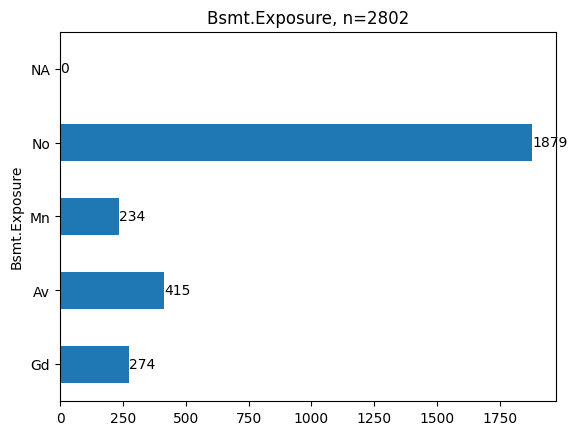

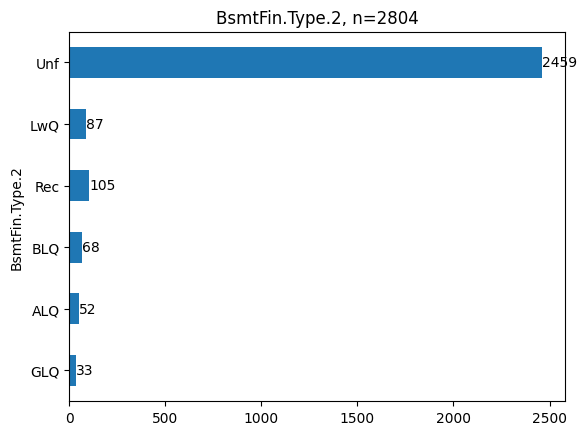

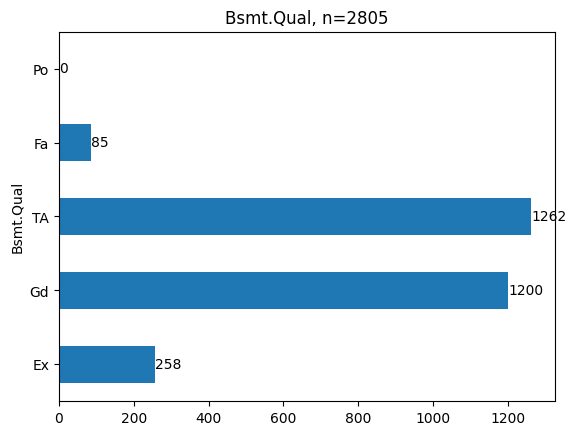

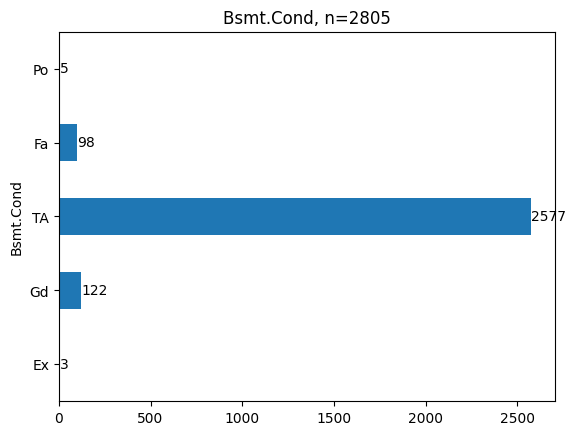

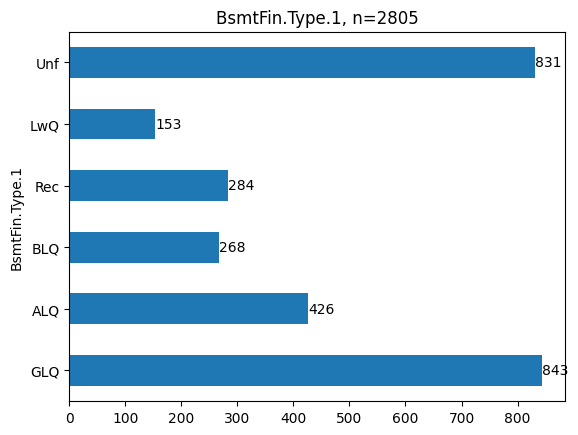

In [360]:
plot_categoricals(
    data,
    [
        'Bsmt.Qual',
        'Bsmt.Cond',
        'Bsmt.Exposure',
        'BsmtFin.Type.1',
        'BsmtFin.Type.2',
    ],
    sorted=False,
)

Para a variável Bsmt.Exposure, vamos atribuir as entradas ausentes à categoria NA. Para todas as outras colunas (Bsmt.Qual, Bsmt.Cond, BsmtFin.Type.1, BsmtFin.Type.2), também vamos criar a categoria NA e atribuir os valores ausentes a essa categoria.

Além disso, como a categoria NA não se encaixa em uma sequência com as outras classes, vamos converter essas colunas para variáveis nominais (ou seja, categóricas sem ordem entre as categorias). Nesse caso, precisaremos eliminar as categorias não utilizadas para manter as colunas mais limpas e consistentes.

In [361]:
data['Bsmt.Exposure'].unique()

['Gd', 'No', 'Mn', 'Av', NaN]
Categories (5, object): ['Gd' < 'Av' < 'Mn' < 'No' < 'NA']

In [362]:
data['Bsmt.Exposure'][data['Bsmt.Exposure'].isna()] = 'NA'
data['Bsmt.Exposure'] = data['Bsmt.Exposure'] \
    .cat \
    .as_unordered() \
    .cat \
    .remove_unused_categories()

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\1180054757.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Bsmt.Exposure'][data['Bsmt.Exposure'].isna()] = 'NA'


In [363]:
for col in ('Bsmt.Qual', 'Bsmt.Cond', 'BsmtFin.Type.1', 'BsmtFin.Type.2'):
    data[col] = data[col].cat.add_categories(['NA'])
    data[col][data[col].isna()] = 'NA'
    data[col] = data[col] \
        .cat \
        .as_unordered() \
        .cat \
        .remove_unused_categories()

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\349378033.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[col][data[col].isna()] = 'NA'
C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\349378033.py:3: FutureWarning: ChainedAssign

               count unique  top  freq
Bsmt.Qual       2880      5   TA  1262
Bsmt.Cond       2880      6   TA  2577
Bsmt.Exposure   2880      5   No  1879
BsmtFin.Type.1  2880      7  GLQ   843
BsmtFin.Type.2  2880      7  Unf  2459


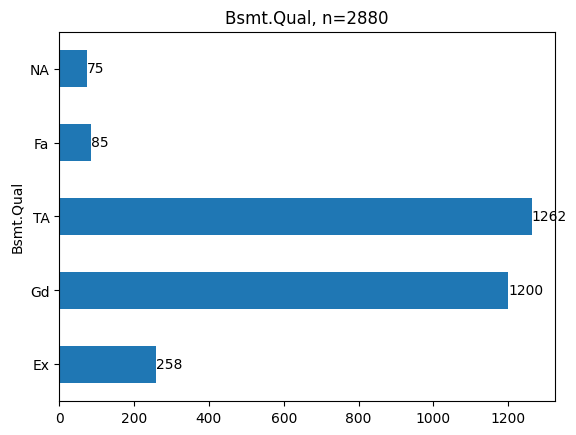

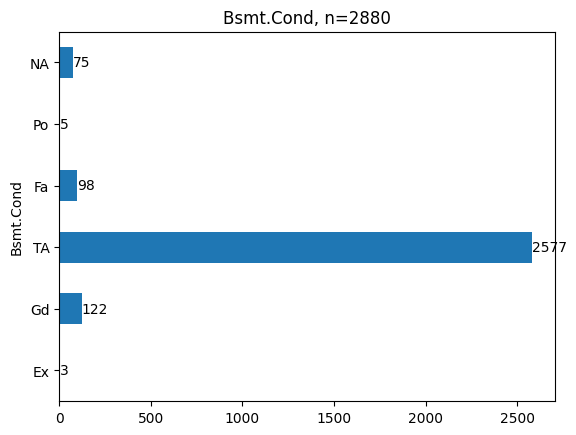

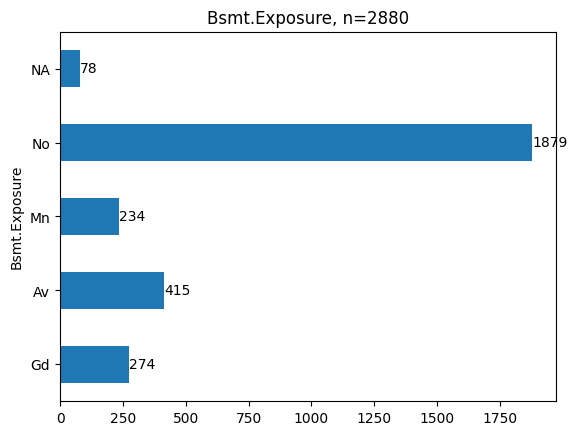

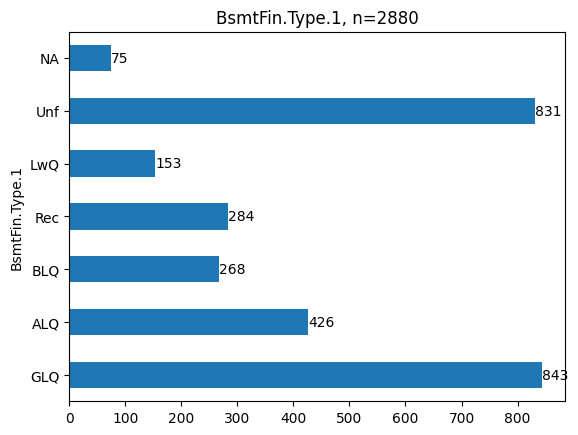

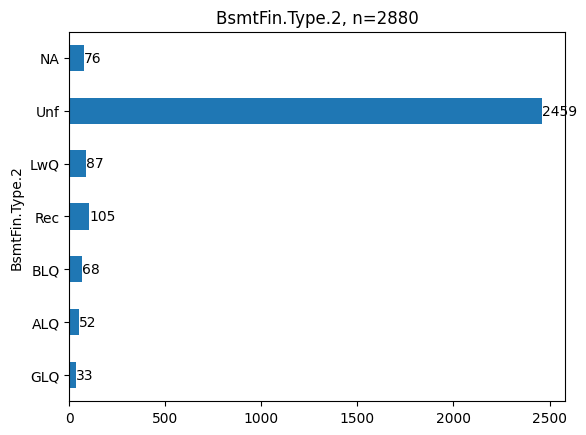

In [364]:
plot_categoricals(
    data,
    [
        'Bsmt.Qual',
        'Bsmt.Cond',
        'Bsmt.Exposure',
        'BsmtFin.Type.1',
        'BsmtFin.Type.2',
    ],
    sorted=False,
)

In [365]:
data['Bsmt.Cond'][data['Bsmt.Cond'] == 'Po'] = 'Fa'
data['Bsmt.Cond'][data['Bsmt.Cond'] == 'Ex'] = 'Gd'
data['Bsmt.Cond'] = data['Bsmt.Cond'].cat.remove_unused_categories()
data['Bsmt.Cond'].value_counts()

C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\3049372714.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Bsmt.Cond'][data['Bsmt.Cond'] == 'Po'] = 'Fa'
C:\Users\giuli\AppData\Local\Temp\ipykernel_23484\3049372714.py:2: FutureWar

Bsmt.Cond
TA    2577
Gd     125
Fa     103
NA      75
Name: count, dtype: int64

##### *Análise das variáveis contínuas*


Vamos procurar por valores ausentes, anomalias, outliers e qualquer outra coisa que possa prejudicar nossa modelagem.

                  count           mean           std      min        25%  \
Lot.Frontage     2397.0      69.472257     23.261537     21.0      59.00   
Garage.Yr.Blt    2731.0    1978.341633     25.388716   1900.0    1960.00   
Mas.Vnr.Area     2857.0     103.596430    180.153725      0.0       0.00   
Bsmt.Full.Bath   2878.0       0.433634      0.525612      0.0       0.00   
Bsmt.Half.Bath   2878.0       0.061849      0.246625      0.0       0.00   
Bsmt.Unf.SF      2879.0     562.549844    440.582493      0.0     222.00   
BsmtFin.SF.1     2879.0     444.993053    456.336521      0.0       0.00   
Total.Bsmt.SF    2879.0    1057.584231    439.306589      0.0     796.00   
Garage.Cars      2879.0       1.774575      0.757336      0.0       1.00   
Garage.Area      2879.0     474.925669    214.001822      0.0     325.50   
BsmtFin.SF.2     2879.0      50.041334    169.929207      0.0       0.00   
Year.Built       2880.0    1971.773264     30.012773   1872.0    1954.00   
Low.Qual.Fin

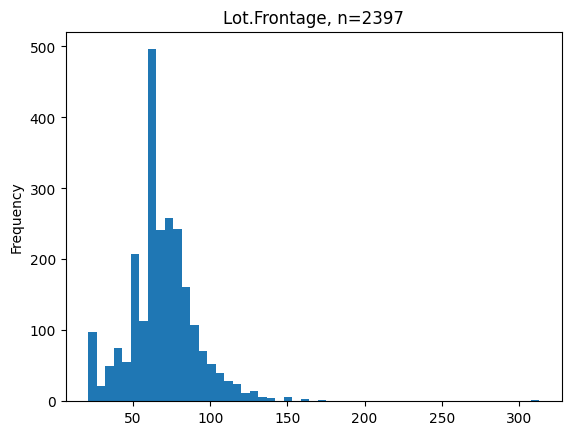

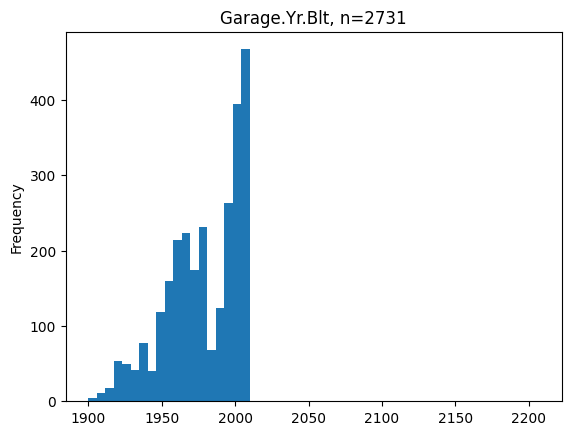

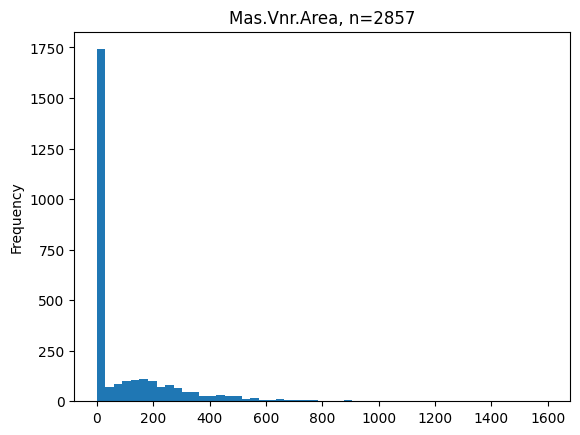

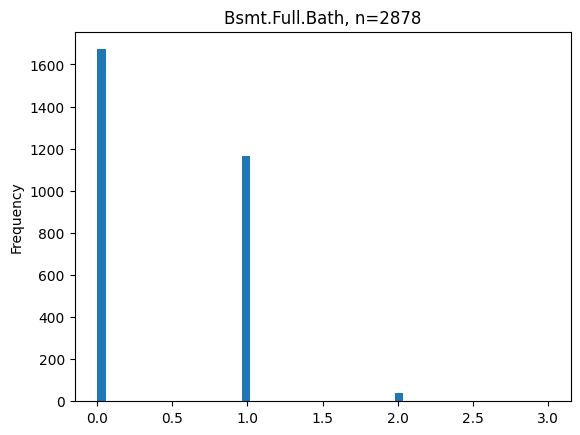

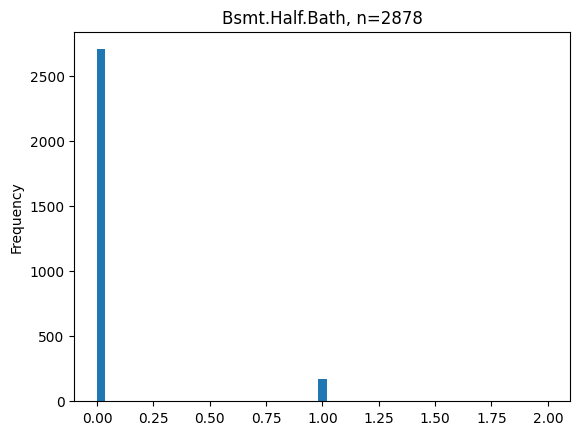

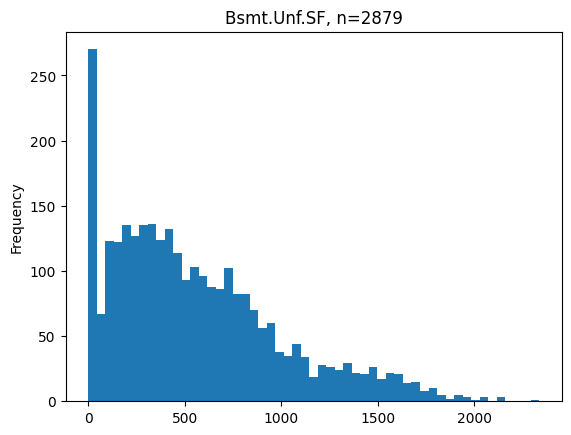

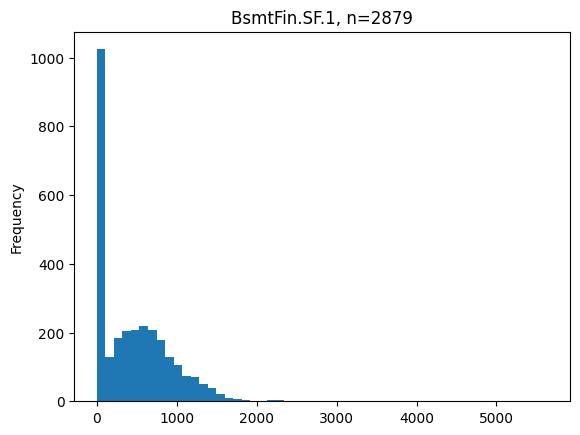

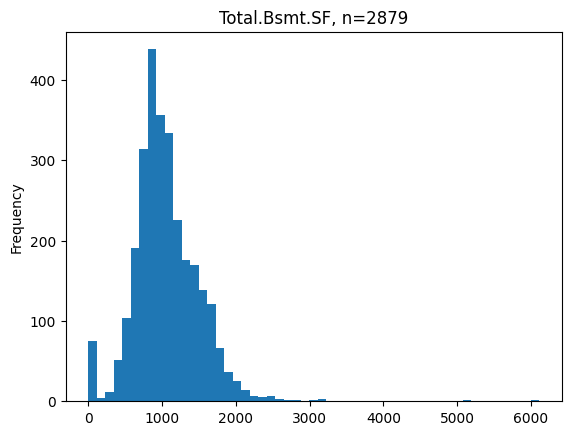

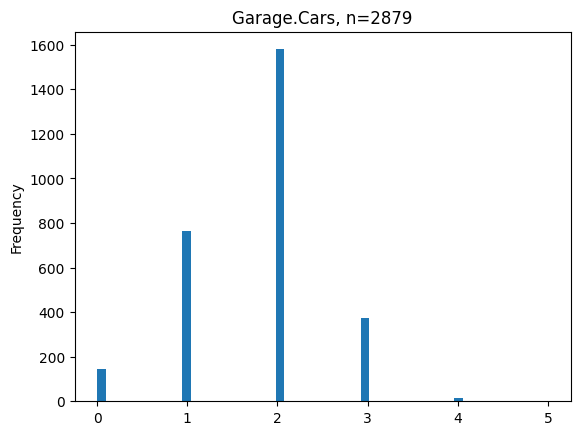

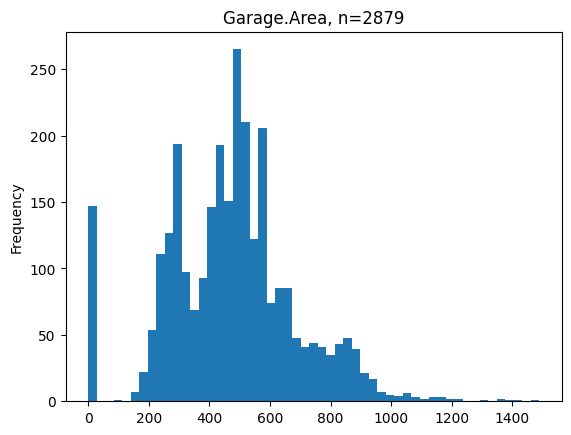

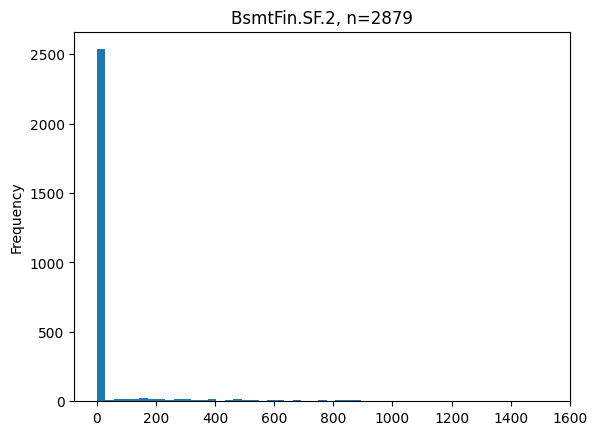

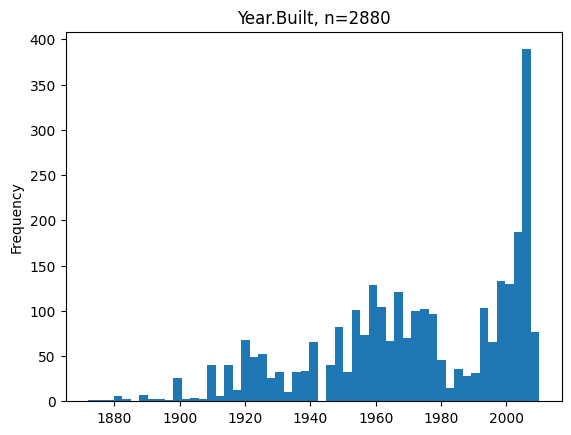

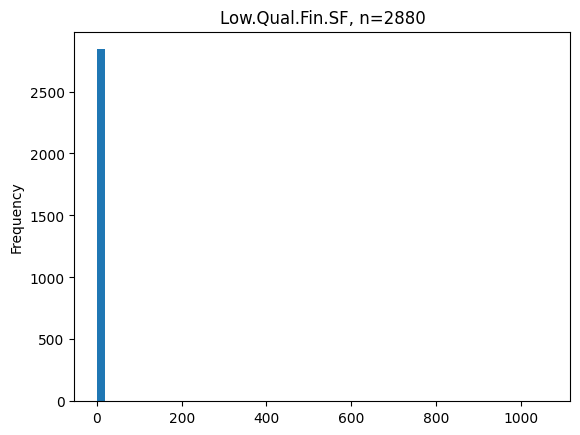

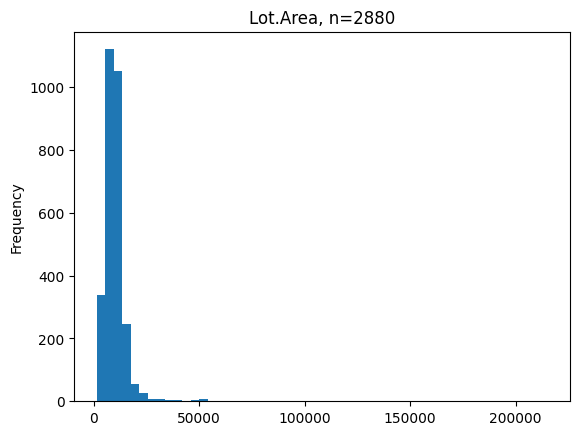

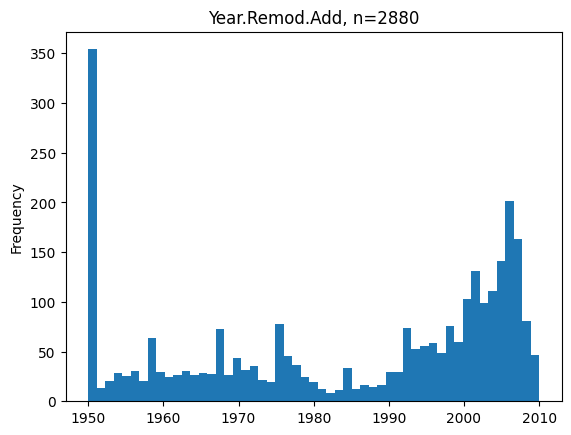

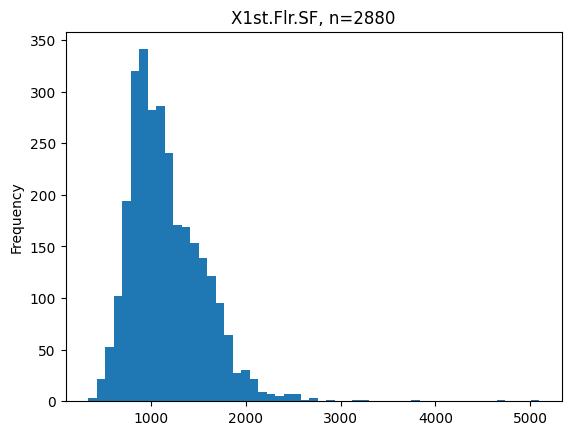

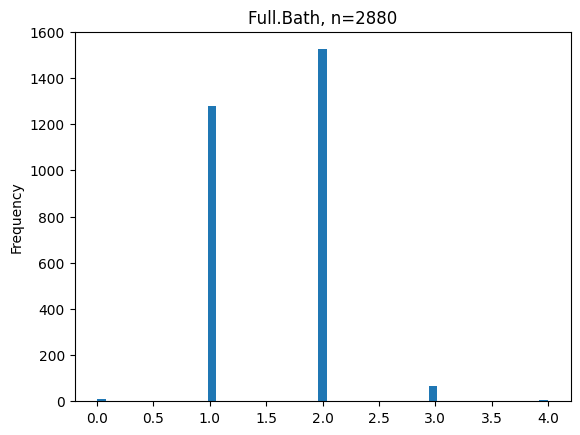

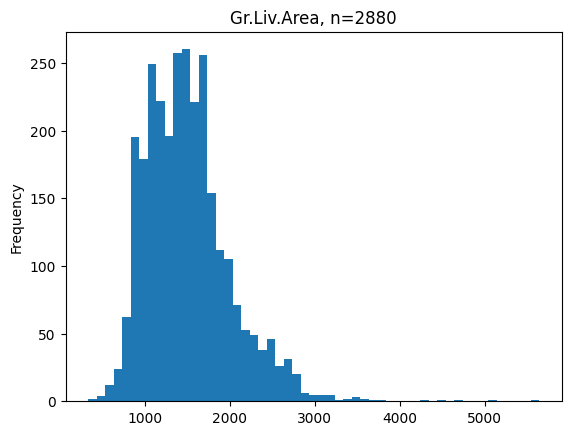

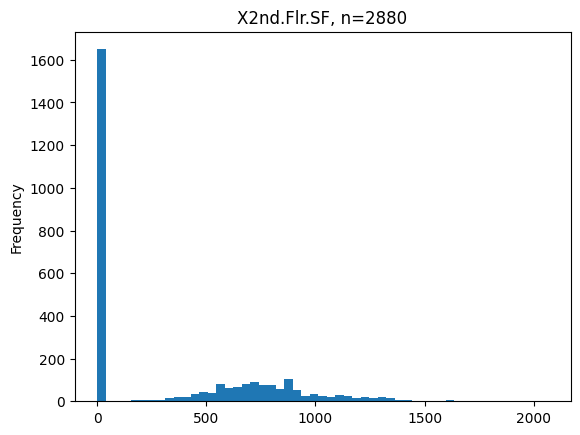

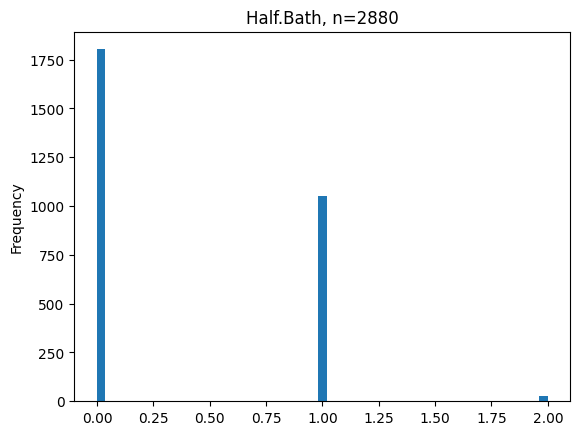

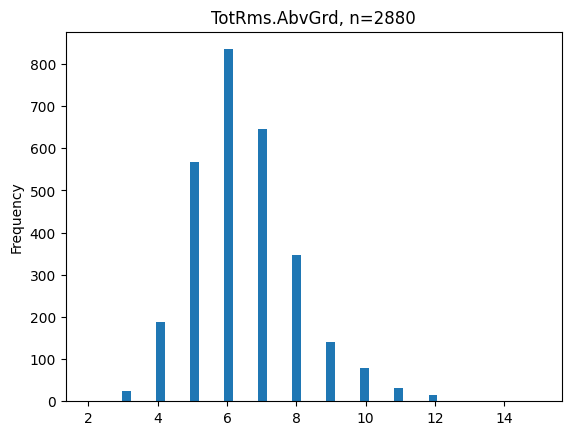

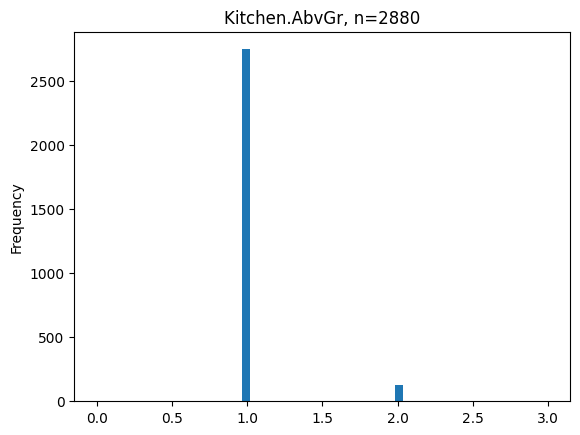

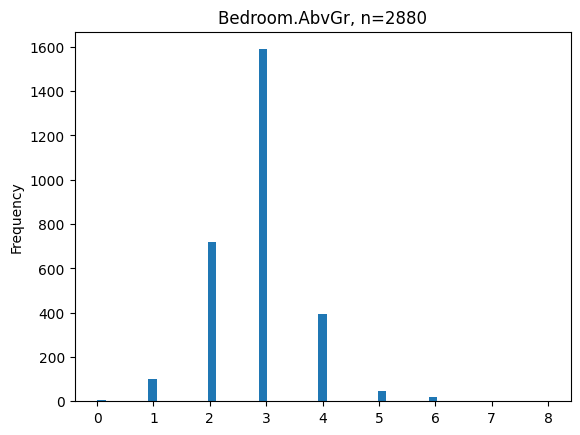

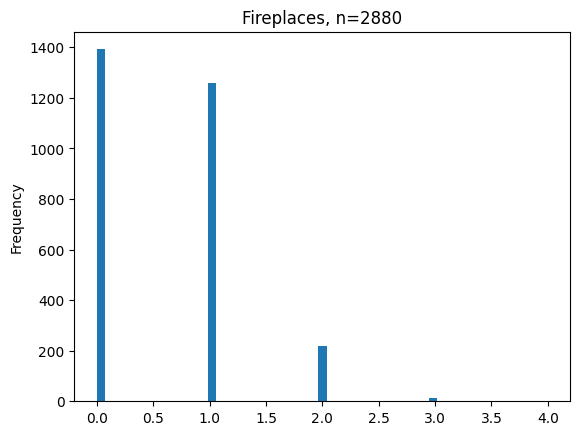

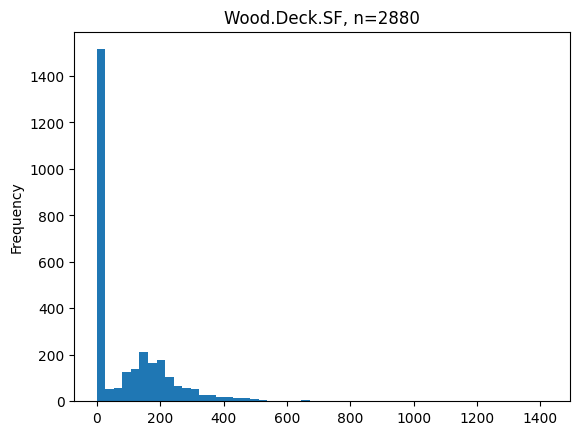

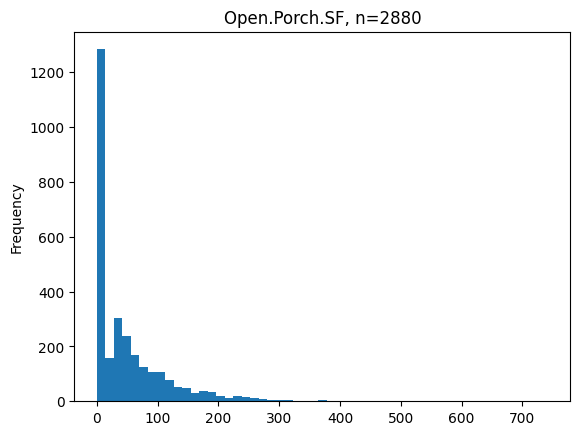

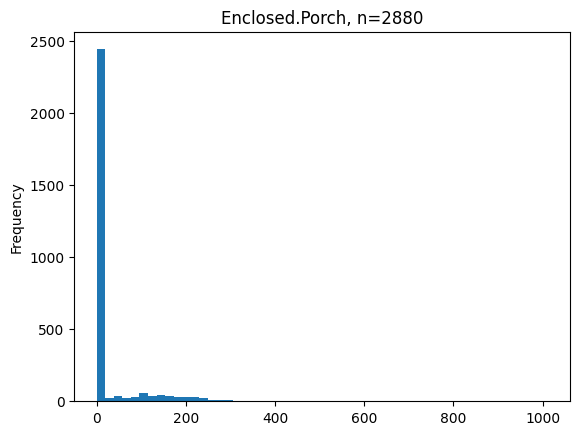

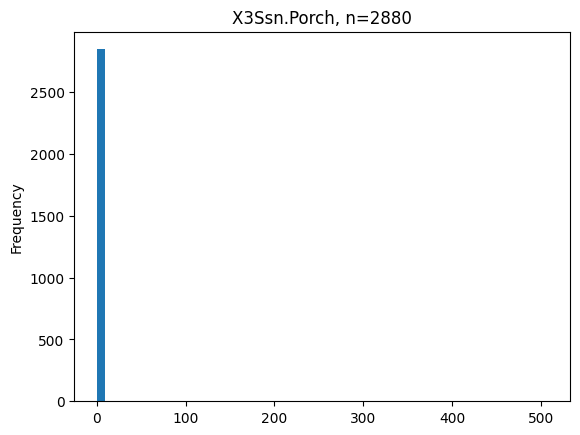

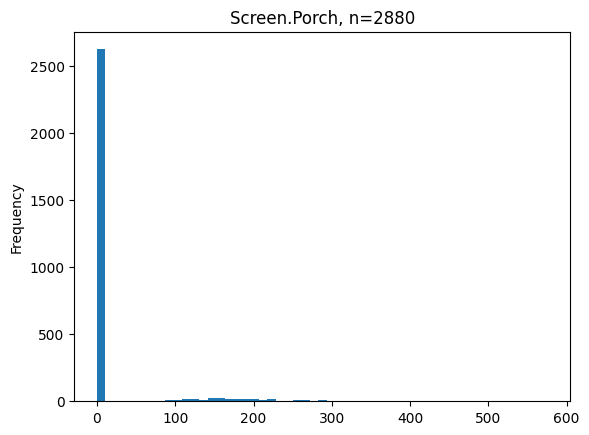

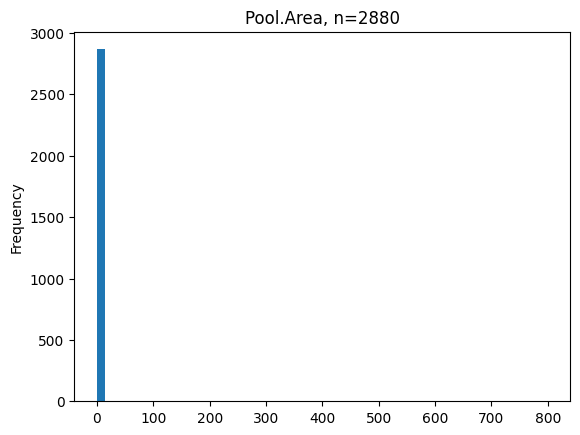

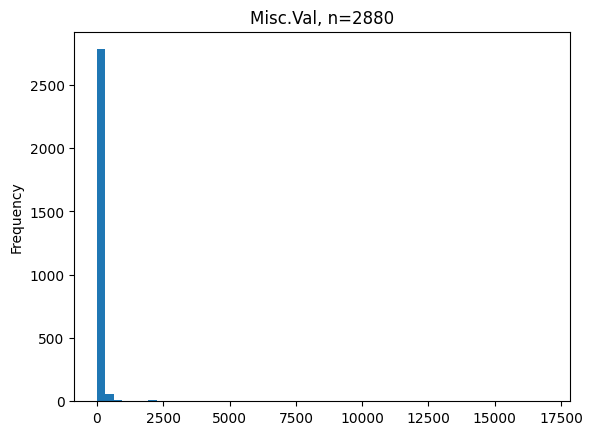

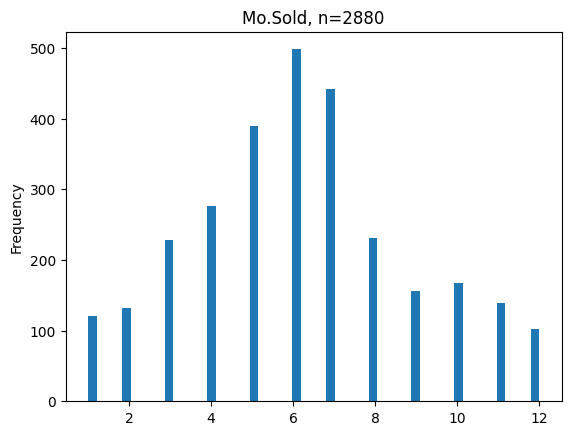

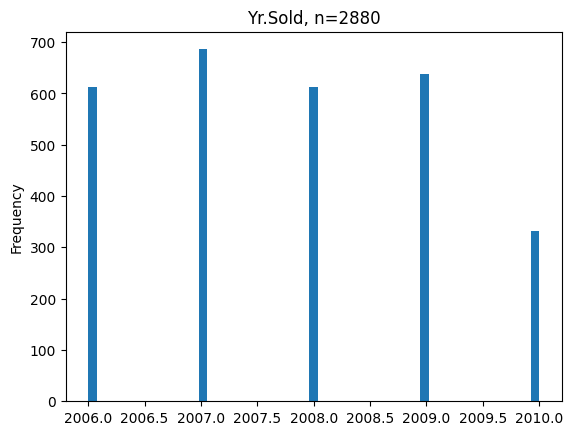

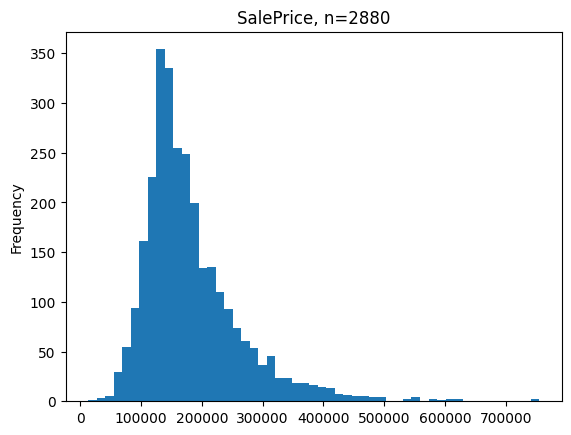

In [367]:
def plot_numericals(data, cols):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    n = data.shape[0]
    b = int(np.sqrt(n))
    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        data[col].plot.hist(bins=b)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

plot_numericals(data, data.select_dtypes('number').columns)

A primeira coluna a ser analisada será o Valor da Venda (SalePrice).


Vamos remapear a variável SalePrice para representar o logaritmo na base 10 do valor original. Qualquer base pode ser utilizada, mas a base 10 é um pouco mais interpretável: um valor de 3 significa milhares, 4 significa dezenas de milhares, 6 significa milhões, e assim por diante.

In [368]:
data['SalePrice'] = data['SalePrice'].apply(np.log10)
data['SalePrice'].describe()

count    2880.000000
mean        5.224370
std         0.172850
min         4.106837
25%         5.113943
50%         5.206826
75%         5.330414
max         5.877947
Name: SalePrice, dtype: float64

A próxima coluna a ser analisada é a coluna Lot.Frontage. 

A coluna Lot.Frontage possui muitos valores ausentes. Vamos preencher esses valores ausentes com a mediana da coluna.

In [369]:
data['Lot.Frontage'] = data['Lot.Frontage'].fillna(data['Lot.Frontage'].median())
data['Lot.Frontage'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Lot.Frontage
Non-Null Count  Dtype  
--------------  -----  
2880 non-null   float64
dtypes: float64(1)
memory usage: 45.0 KB


Agora vamos analisar a coluna Ano de Construção da Garagem (Garage.Yr.Blt).

In [370]:
data['Garage.Yr.Blt'].describe()

count    2731.000000
mean     1978.341633
std        25.388716
min      1900.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: Garage.Yr.Blt, dtype: float64

In [371]:
garage_age = data['Yr.Sold'] - data['Garage.Yr.Blt']
garage_age.describe()

count    2731.000000
mean       29.443061
std        25.425924
min      -200.000000
25%         6.000000
50%        28.000000
75%        47.500000
max       110.000000
dtype: float64

In [372]:
data[garage_age < 0.0].transpose()

,2180,2260
MS.SubClass,20,20
MS.Zoning,RL,RL
Lot.Frontage,128.0,68.0
Lot.Area,39290.0,8298.0
Lot.Shape,IR1,IR1
Land.Contour,Bnk,HLS
Lot.Config,Inside,Inside
Land.Slope,Gtl,Gtl
Neighborhood,Edwards,Timber
Bldg.Type,1Fam,1Fam


In [373]:
garage_age[garage_age < 0.0] = 0.0

In [374]:
data = data.drop(columns='Garage.Yr.Blt')
data['Garage.Age'] = garage_age

In [375]:
data['Garage.Age'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Garage.Age
Non-Null Count  Dtype  
--------------  -----  
2731 non-null   float64
dtypes: float64(1)
memory usage: 45.0 KB


In [376]:
data['Garage.Type'][data['Garage.Age'].isna()].value_counts()

Garage.Type
NoGarage    147
Detchd        2
2Types        0
Basment       0
Attchd        0
CarPort       0
BuiltIn       0
Name: count, dtype: int64

In [377]:
data['Garage.Age'] = data['Garage.Age'].fillna(data['Garage.Age'].median())

Vamos agora aplicar a mesma lógica para a coluna Ano de Construção da Casa (Year.Built) e para a coluna Ano de Reforma (Year.Remod.Add).

In [378]:
data[['Year.Remod.Add', 'Year.Built', 'Yr.Sold']].describe()

,Year.Remod.Add,Year.Built,Yr.Sold
count,2880.000000,2880.000000,2880.000000
mean,1984.514236,1971.773264,2007.788542
std,20.799105,30.012773,1.313914
min,1950.000000,1872.000000,2006.000000
25%,1966.000000,1954.000000,2007.000000
50%,1993.000000,1973.000000,2008.000000
75%,2004.000000,2001.000000,2009.000000
max,2010.000000,2010.000000,2010.000000


In [379]:
remod_age = data['Yr.Sold'] - data['Year.Remod.Add']
remod_age.describe()

count    2880.000000
mean       23.274306
std        20.792340
min        -2.000000
25%         4.000000
50%        15.000000
75%        42.000000
max        60.000000
dtype: float64

In [380]:

data[remod_age < 0.0].transpose()

,1702,2180,2181
MS.SubClass,60,20,60
MS.Zoning,RL,RL,RL
Lot.Frontage,134.0,128.0,130.0
Lot.Area,16659.0,39290.0,40094.0
Lot.Shape,IR1,IR1,IR1
Land.Contour,Lvl,Bnk,Bnk
Lot.Config,Corner,Inside,Inside
Land.Slope,Gtl,Gtl,Gtl
Neighborhood,NridgHt,Edwards,Edwards
Bldg.Type,1Fam,1Fam,1Fam


In [381]:
remod_age[remod_age < 0.0] = 0.0
house_age = data['Yr.Sold'] - data['Year.Built']
house_age.describe()

count    2880.000000
mean       36.015278
std        30.053254
min        -1.000000
25%         7.000000
50%        34.000000
75%        54.000000
max       136.000000
dtype: float64

In [382]:
data[house_age < 0.0].transpose()

,2180
MS.SubClass,20
MS.Zoning,RL
Lot.Frontage,128.0
Lot.Area,39290.0
Lot.Shape,IR1
Land.Contour,Bnk
Lot.Config,Inside
Land.Slope,Gtl
Neighborhood,Edwards
Bldg.Type,1Fam


In [383]:
house_age[house_age < 0.0] = 0.0
data = data.drop(columns=['Year.Remod.Add', 'Year.Built'])
data['Remod.Age'] = remod_age
data['House.Age'] = house_age

Vamos para a analise da coluna Mas.Vnr.Area.

In [384]:
data['Mas.Vnr.Area'].info()

<class 'pandas.core.series.Series'>
Index: 2880 entries, 0 to 2929
Series name: Mas.Vnr.Area
Non-Null Count  Dtype  
--------------  -----  
2857 non-null   float64
dtypes: float64(1)
memory usage: 45.0 KB


In [385]:
data['Mas.Vnr.Type'][data['Mas.Vnr.Area'].isna()].value_counts()

Mas.Vnr.Type
None       23
BrkFace     0
Stone       0
Other       0
Name: count, dtype: int64

In [386]:
data.loc[data['Mas.Vnr.Area'].isna(), 'Mas.Vnr.Area'] = 0.0

##### *Ajustes Finais*

In [387]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2880 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2880 non-null   category
 1   MS.Zoning        2880 non-null   category
 2   Lot.Frontage     2880 non-null   float64 
 3   Lot.Area         2880 non-null   float64 
 4   Lot.Shape        2880 non-null   category
 5   Land.Contour     2880 non-null   category
 6   Lot.Config       2880 non-null   category
 7   Land.Slope       2880 non-null   category
 8   Neighborhood     2880 non-null   category
 9   Bldg.Type        2880 non-null   category
 10  House.Style      2880 non-null   category
 11  Overall.Qual     2880 non-null   category
 12  Overall.Cond     2880 non-null   category
 13  Roof.Style       2880 non-null   category
 14  Mas.Vnr.Type     2880 non-null   category
 15  Mas.Vnr.Area     2880 non-null   float64 
 16  Exter.Qual       2880 non-null   category
 17  

In [388]:
data = data.dropna(axis=0)

In [389]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2876 entries, 0 to 2929
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MS.SubClass      2876 non-null   category
 1   MS.Zoning        2876 non-null   category
 2   Lot.Frontage     2876 non-null   float64 
 3   Lot.Area         2876 non-null   float64 
 4   Lot.Shape        2876 non-null   category
 5   Land.Contour     2876 non-null   category
 6   Lot.Config       2876 non-null   category
 7   Land.Slope       2876 non-null   category
 8   Neighborhood     2876 non-null   category
 9   Bldg.Type        2876 non-null   category
 10  House.Style      2876 non-null   category
 11  Overall.Qual     2876 non-null   category
 12  Overall.Cond     2876 non-null   category
 13  Roof.Style       2876 non-null   category
 14  Mas.Vnr.Type     2876 non-null   category
 15  Mas.Vnr.Area     2876 non-null   float64 
 16  Exter.Qual       2876 non-null   category
 17  

In [390]:
for col in data.select_dtypes('category').columns:
    data[col] = data[col].cat.remove_unused_categories()

##### *Salva o dataset processado*

In [391]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

In [392]:
with open(clean_data_path, 'wb') as file:
    pickle.dump(data, file)